In [2]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\tomas\Desktop\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB 


In [3]:
"""
UC + Renewable (curtailable) + Demand Shifting (global neutrality)
Option A initial conditions (u_init, p_init, on/off carryover for min up/down)

Requirements:
  pip install gurobipy numpy

Note:
  - This is a self-contained synthetic example (24h, 3 thermal units, 1 renewable).
  - Extend by replacing the DATA section with your real inputs.
"""

import numpy as np
import gurobipy as gp
from gurobipy import GRB


# ============================================================
# DATA (Synthetic 24-hour instance)
# ============================================================
nT = 24
T = range(nT)

# Demand (MW)
D = 0.75*np.array([
    800, 780, 760, 750, 770, 820, 880, 950,
    1020, 1100, 1200, 1250, 1300, 1280, 1230,
    1150, 1080, 1030, 990, 950, 910, 870, 840, 820
], dtype=float)

# Renewables (MW availability) - 1 renewable profile (e.g., wind+solar aggregate)
R_avail = 3 * np.array([[
    0, 0, 0, 0, 20, 60, 120, 180,
    240, 280, 300, 310, 300, 280, 250,
    180, 120, 80, 40, 20, 0, 0, 0, 0
]], dtype=float)
nR = R_avail.shape[0]
R = range(nR)

# Thermal generators (3 units)
Pmin = np.array([100, 150, 200], dtype=float)
Pmax = np.array([500, 600, 700], dtype=float)
c    = np.array([20,  30,  40 ], dtype=float)     # $/MWh
SU_cost = np.array([500, 800, 1200], dtype=float) # $ per startup
SD_cost = np.array([200, 300, 400 ], dtype=float) # $ per shutdown (can be 0)

# UC dynamics
RU = np.array([100, 100, 150], dtype=float)  # MW/h
RD = np.array([100, 100, 150], dtype=float)  # MW/h
UT = np.array([3, 4, 5], dtype=int)          # hours
DT = np.array([2, 3, 3], dtype=int)          # hours

# Option A initial conditions (given from previous horizon)
u_init = np.array([1, 0, 0], dtype=int)      # u_g,0
p_init = np.array([300, 0, 0], dtype=float)  # p_g,0
on_time_init  = np.array([5, 0, 0], dtype=int)   # consecutive ON hours prior to t=0
off_time_init = np.array([0, 10, 10], dtype=int) # consecutive OFF hours prior to t=0

# Demand shifting (global neutrality only)
Splus_max  = np.array([50]*nT, dtype=float)     # MW each hour
Sminus_max = np.array([50]*nT, dtype=float)
pi_plus    = np.array([100]*nT, dtype=float)    # $/MWh shifted into hour t
pi_minus   = np.array([100]*nT, dtype=float)

# Curtailment penalty (0 = allow free curtailment)
kappa = np.zeros((nR, nT), dtype=float)


# ============================================================
# MODEL / SOLVER
# ============================================================
def solve_uc_renew_shift(
    D, R_avail,
    Pmin, Pmax, c, SU_cost, SD_cost,
    RU, RD, UT, DT,
    u_init, p_init, on_time_init, off_time_init,
    Splus_max, Sminus_max, pi_plus, pi_minus,
    kappa,
    output_flag=1
):
    nT = len(D)
    nR, nT2 = R_avail.shape
    assert nT2 == nT
    nG = len(Pmin)

    G = range(nG)
    R = range(nR)
    T = range(nT)

    m = gp.Model("UC_Renew_Shift_GlobalNeutrality")
    m.Params.OutputFlag = output_flag

    # -----------------------
    # Variables
    # -----------------------
    u = m.addVars(G, T, vtype=GRB.BINARY, name="u")         # on/off
    v = m.addVars(G, T, vtype=GRB.BINARY, name="v")         # startup
    w = m.addVars(G, T, vtype=GRB.BINARY, name="w")         # shutdown
    p = m.addVars(G, T, lb=0.0, vtype=GRB.CONTINUOUS, name="p")

    pR   = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="pR")
    curt = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="curt")

    splus  = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="splus")
    sminus = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="sminus")

    # -----------------------
    # Objective
    # -----------------------
    obj = gp.quicksum(
        c[g] * p[g, t] + SU_cost[g] * v[g, t] + SD_cost[g] * w[g, t]
        for g in G for t in T
    )
    obj += gp.quicksum(pi_plus[t] * splus[t] + pi_minus[t] * sminus[t] for t in T)
    obj += gp.quicksum(float(kappa[r, t]) * curt[r, t] for r in R for t in T)
    m.setObjective(obj, GRB.MINIMIZE)

    # -----------------------
    # Constraints
    # -----------------------

    # (1) Balance with shifting
    for t in T:
        m.addConstr(
            gp.quicksum(p[g, t] for g in G) + gp.quicksum(pR[r, t] for r in R)
            == float(D[t]) + splus[t] - sminus[t],
            name=f"balance[{t}]"
        )

    # (2) Renewable availability with explicit curtailment
    for r in R:
        for t in T:
            m.addConstr(
                pR[r, t] + curt[r, t] == float(R_avail[r, t]),
                name=f"ren_avail[{r},{t}]"
            )

    # (3) Global neutrality: total shifted in = total shifted out
    m.addConstr(gp.quicksum(splus[t] for t in T) == gp.quicksum(sminus[t] for t in T),
                name="shift_neutrality")

    # (4) Shift bounds
    for t in T:
        m.addConstr(splus[t]  <= float(Splus_max[t]),  name=f"splus_max[{t}]")
        m.addConstr(sminus[t] <= float(Sminus_max[t]), name=f"sminus_max[{t}]")

    # (5) Thermal capacity limits
    for g in G:
        for t in T:
            m.addConstr(p[g, t] >= float(Pmin[g]) * u[g, t], name=f"pmin[{g},{t}]")
            m.addConstr(p[g, t] <= float(Pmax[g]) * u[g, t], name=f"pmax[{g},{t}]")

    # (6) Commitment transitions with Option A initial conditions
    for g in G:
        m.addConstr(u[g, 0] - int(u_init[g]) == v[g, 0] - w[g, 0], name=f"logic_init[{g}]")
        for t in range(1, nT):
            m.addConstr(u[g, t] - u[g, t-1] == v[g, t] - w[g, t], name=f"logic[{g},{t}]")
        for t in T:
            m.addConstr(v[g, t] + w[g, t] <= 1, name=f"no_simul[{g},{t}]")

    # (7) Ramping with commitment logic (recommended)
    # If you have explicit startup/shutdown ramp limits, use them:
    #   SU_ramp[g], SD_ramp[g] in MW/h.
    # If not available, fall back to big-M = Pmax[g].

    SU_ramp = Pmax.copy()  # replace with real startup ramps if you have them
    SD_ramp = Pmax.copy()  # replace with real shutdown ramps if you have them

    for g in G:
        # First period ramping vs initial output p_init[g]
        # Up-ramp into t=0 (startup allowed via v[g,0])
        m.addConstr(
            p[g, 0] - float(p_init[g])
            <= float(RU[g]) * int(u_init[g]) + float(SU_ramp[g]) * v[g, 0],
            name=f"ramp_up_init[{g}]"
        )
        # Down-ramp into t=0 (shutdown allowed via w[g,0])
        m.addConstr(
            float(p_init[g]) - p[g, 0]
            <= float(RD[g]) * u[g, 0] + float(SD_ramp[g]) * w[g, 0],
            name=f"ramp_dn_init[{g}]"
        )

        # Subsequent periods
        for t in range(1, nT):
            m.addConstr(
                p[g, t] - p[g, t-1]
                <= float(RU[g]) * u[g, t-1] + float(SU_ramp[g]) * v[g, t],
                name=f"ramp_up[{g},{t}]"
            )
            m.addConstr(
                p[g, t-1] - p[g, t]
                <= float(RD[g]) * u[g, t] + float(SD_ramp[g]) * w[g, t],
                name=f"ramp_dn[{g},{t}]"
            )

    # (8) Min up/down with carryover (Option A)
    for g in G:
        UTg = int(UT[g])
        DTg = int(DT[g])

        # Carryover at boundary (remaining required on/off time)
        if int(u_init[g]) == 1:
            rem_up = max(0, UTg - int(on_time_init[g]))
            for t in range(min(rem_up, nT)):
                m.addConstr(u[g, t] == 1, name=f"carry_up[{g},{t}]")

        if int(u_init[g]) == 0:
            rem_dn = max(0, DTg - int(off_time_init[g]))
            for t in range(min(rem_dn, nT)):
                m.addConstr(u[g, t] == 0, name=f"carry_dn[{g},{t}]")

        # Standard within-horizon min up/down constraints
        for t in T:
            start = max(0, t - UTg + 1)
            m.addConstr(
                gp.quicksum(v[g, tau] for tau in range(start, t+1)) <= u[g, t],
                name=f"min_up[{g},{t}]"
            )

        for t in T:
            start = max(0, t - DTg + 1)
            m.addConstr(
                gp.quicksum(w[g, tau] for tau in range(start, t+1)) <= 1 - u[g, t],
                name=f"min_dn[{g},{t}]"
            )

    # Solve
    m.optimize()

    # Collect solution
    if m.status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        raise RuntimeError(f"Gurobi ended with status {m.status}.")

    sol = {
        "obj": m.objVal,
        "u": np.array([[u[g, t].X for t in T] for g in G]),
        "v": np.array([[v[g, t].X for t in T] for g in G]),
        "w": np.array([[w[g, t].X for t in T] for g in G]),
        "p": np.array([[p[g, t].X for t in T] for g in G]),
        "pR": np.array([[pR[r, t].X for t in T] for r in R]),
        "curt": np.array([[curt[r, t].X for t in T] for r in R]),
        "splus": np.array([splus[t].X for t in T]),
        "sminus": np.array([sminus[t].X for t in T]),
    }
    return sol


if __name__ == "__main__":
    sol = solve_uc_renew_shift(
        D=D, R_avail=R_avail,
        Pmin=Pmin, Pmax=Pmax, c=c, SU_cost=SU_cost, SD_cost=SD_cost,
        RU=RU, RD=RD, UT=UT, DT=DT,
        u_init=u_init, p_init=p_init, on_time_init=on_time_init, off_time_init=off_time_init,
        Splus_max=Splus_max, Sminus_max=Sminus_max, pi_plus=pi_plus, pi_minus=pi_minus,
        kappa=kappa,
        output_flag=1
    )

    print("\n=== Solution summary ===")
    print("Objective value:", sol["obj"])

    total_renew_avail = float(R_avail.sum())
    total_renew_used  = float(sol["pR"].sum())
    total_curt        = float(sol["curt"].sum())
    print(f"Renewables: avail={total_renew_avail:.1f} used={total_renew_used:.1f} curtailed={total_curt:.1f}")

    total_shift_in  = float(sol["splus"].sum())
    total_shift_out = float(sol["sminus"].sum())
    print(f"Shifting: in={total_shift_in:.2f} out={total_shift_out:.2f} (should match)")

    # Optional quick checks
    balance_residual = []
    for t in range(nT):
        lhs = sol["p"][:, t].sum() + sol["pR"][:, t].sum()
        rhs = D[t] + sol["splus"][t] - sol["sminus"][t]
        balance_residual.append(lhs - rhs)
    print("Max balance residual:", np.max(np.abs(balance_residual)))

    # Print schedules
    print("\nThermal commitment u[g,t]:")
    for g in range(len(Pmin)):
        print(f"g={g}:", sol["u"][g, :].astype(int).tolist())

    print("\nThermal dispatch p[g,t] (MW):")
    for g in range(len(Pmin)):
        print(f"g={g}:", [round(x, 1) for x in sol["p"][g, :].tolist()])

    print("\nRenewable used pR[r,t] (MW):")
    for r in range(R_avail.shape[0]):
        print(f"r={r}:", [round(x, 1) for x in sol["pR"][r, :].tolist()])

    print("\nCurtailment curt[r,t] (MW):")
    for r in range(R_avail.shape[0]):
        print(f"r={r}:", [round(x, 1) for x in sol["curt"][r, :].tolist()])

    print("\nShift net (splus - sminus) (MW):")
    net_shift = sol["splus"] - sol["sminus"]
    print([round(x, 1) for x in net_shift.tolist()])


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653481
Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 673 rows, 384 columns and 2170 nonzeros (Min)
Model fingerprint: 0xb25203e5
Model has 264 linear objective coefficients
Variable types: 168 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [2e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 114 rows and 46 columns
Presolve time: 0.01s
Presolved: 559 rows, 338 c

In [4]:
# ============================================================
# NCXplain (Weak CE) for UC with renewables + demand shifting
# Goal foil: 0 curtailment (curt[r,t] = 0 for all r,t)
# Mutable parameters: ONLY shift costs (coefficients on splus/sminus)
#
# Run this whole cell top-to-bottom in a fresh kernel.
# Requirements: pip install gurobipy numpy
# ============================================================

from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List, Sequence, Tuple, Optional, Dict
import math
import numpy as np
import gurobipy as gp
from gurobipy import GRB

Vector = List[float]
ForwardBuilder = Callable[[gp.Model], Tuple[List[gp.Var], List[str]]]
FoilBuilder = Callable[[gp.Model, List[gp.Var], List[str]], None]

# =========================
# Data structures
# =========================
@dataclass(frozen=True)
class DomainD:
    lb: Sequence[float]
    ub: Sequence[float]

@dataclass
class NCXplainResult:
    status: str
    d_star: Optional[List[float]] = None
    x_foil: Optional[List[float]] = None
    iters: int = 0
    cuts_added: int = 0


# =========================
# NCXplain helpers
# =========================
def dot(a: Sequence[float], b: Sequence[float]) -> float:
    return sum(float(ai) * float(bi) for ai, bi in zip(a, b))

def _get_solution_vector(x_vars: List[gp.Var]) -> Vector:
    return [float(v.X) for v in x_vars]

def _dot_affine(d_vars: List[gp.Var], x_vals: Sequence[float]) -> gp.LinExpr:
    expr = gp.LinExpr()
    for dj, xj in zip(d_vars, x_vals):
        xj = float(xj)
        if abs(xj) > 0:
            expr.add(dj, xj)
    return expr

def _dot_bilinear(d_vars: List[gp.Var], x_vars: List[gp.Var]) -> gp.QuadExpr:
    q = gp.QuadExpr()
    for dj, xj in zip(d_vars, x_vars):
        q.add(dj * xj)
    return q

def _is_equal(a: float, b: float, tol: float) -> bool:
    return abs(a - b) <= tol * (1.0 + max(abs(a), abs(b)))

def _is_strictly_less(a: float, b: float, tol: float) -> bool:
    return (b - a) > tol * (1.0 + max(abs(a), abs(b)))


# =========================
# Forward SP: solve min d^T x
# =========================
def solve_forward_SP(
    forward_builder: ForwardBuilder,
    d: Sequence[float],
    time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> Tuple[str, Vector, float, List[str]]:
    m = gp.Model("SP_forward")
    m.Params.OutputFlag = output_flag
    if time_limit is not None:
        m.Params.TimeLimit = time_limit

    x_vars, var_names = forward_builder(m)

    if len(d) != len(x_vars):
        raise ValueError(f"Length mismatch: len(d)={len(d)} vs len(x_vars)={len(x_vars)}")

    obj = gp.LinExpr()
    for coeff, var in zip(d, x_vars):
        coeff = float(coeff)
        if abs(coeff) > 0:
            obj.add(var, coeff)
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return "OPTIMAL", _get_solution_vector(x_vars), float(m.ObjVal), var_names
    if m.Status in (GRB.INFEASIBLE, GRB.INF_OR_UNBD):
        return "INFEASIBLE", [], math.inf, var_names
    return f"STATUS_{m.Status}", [], math.inf, var_names


# =========================
# Foil membership: is x_candidate feasible + satisfies foil constraints?
# =========================
def is_in_foil_region(
    forward_builder: ForwardBuilder,
    foil_builder: FoilBuilder,
    x_candidate: Sequence[float],
    output_flag: int = 0,
) -> bool:
    m = gp.Model("foil_membership")
    m.Params.OutputFlag = output_flag

    x_vars, var_names = forward_builder(m)
    foil_builder(m, x_vars, var_names)

    if len(x_candidate) != len(x_vars):
        return False

    for j, (v, val) in enumerate(zip(x_vars, x_candidate)):
        m.addConstr(v == float(val), name=f"fix[{j}]")

    m.setObjective(0.0, GRB.MINIMIZE)
    m.optimize()
    return m.Status == GRB.OPTIMAL


# =========================
# Master MP for NCXplain (min ||d-c||_1 s.t. x_foil is weakly optimal)
# =========================
def solve_master_MPNCE(
    forward_builder: ForwardBuilder,
    foil_builder: FoilBuilder,
    c: Sequence[float],
    domain_d: DomainD,
    S0: List[Vector],
    time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> Tuple[str, List[float], Vector, float, List[str]]:
    n = len(c)
    if len(domain_d.lb) != n or len(domain_d.ub) != n:
        raise ValueError("Domain bounds must match len(c).")
    if len(S0) == 0:
        raise ValueError("S0 must start non-empty (use factual x*).")

    m = gp.Model("MP_NCE")
    m.Params.OutputFlag = output_flag
    if time_limit is not None:
        m.Params.TimeLimit = time_limit
    m.Params.NonConvex = 2  # bilinear terms

    x_vars, var_names = forward_builder(m)
    foil_builder(m, x_vars, var_names)

    if len(x_vars) != n:
        raise ValueError(f"MP: len(x_vars)={len(x_vars)} must equal len(c)={n}")

    g = m.addVars(n, lb=0.0, name="g")
    h = m.addVars(n, lb=0.0, name="h")
    d_vars = m.addVars(n, lb=-GRB.INFINITY, name="d")

    for j in range(n):
        m.addConstr(d_vars[j] == float(c[j]) - g[j] + h[j], name=f"def_d[{j}]")
        m.addConstr(d_vars[j] >= float(domain_d.lb[j]), name=f"d_lb[{j}]")
        m.addConstr(d_vars[j] <= float(domain_d.ub[j]), name=f"d_ub[{j}]")

    # Cuts: d·x_foil <= d·x0 for each previously-seen x0 in S0
    for k, x0 in enumerate(S0):
        if len(x0) != n:
            raise ValueError(f"S0[{k}] length mismatch.")
        lhs = _dot_bilinear([d_vars[j] for j in range(n)], x_vars)
        rhs = _dot_affine([d_vars[j] for j in range(n)], x0)
        m.addQConstr(lhs <= rhs, name=f"cut[{k}]")

    m.setObjective(g.sum() + h.sum(), GRB.MINIMIZE)
    m.optimize()

    # Accept optimal
    if m.Status == GRB.OPTIMAL:
        d_star = [float(d_vars[j].X) for j in range(n)]
        x_star = _get_solution_vector(x_vars)
        return "OPTIMAL", d_star, x_star, float(m.ObjVal), var_names

    # Accept best incumbent at time limit
    if m.Status == GRB.TIME_LIMIT and m.SolCount > 0:
        d_star = [float(d_vars[j].X) for j in range(n)]
        x_star = _get_solution_vector(x_vars)
        return "TIME_LIMIT", d_star, x_star, float(m.ObjVal), var_names

    if m.Status in (GRB.INFEASIBLE, GRB.INF_OR_UNBD):
        return "INFEASIBLE", [], [], math.inf, var_names

    return f"STATUS_{m.Status}", [], [], math.inf, var_names

# =========================
# NCXplain loop
# =========================
def ncxplain(
    forward_builder: ForwardBuilder,
    foil_builder: FoilBuilder,
    c: Sequence[float],
    domain_d: DomainD,
    x_factual: Vector,
    max_iters: int = 200,
    tol: float = 1e-7,
    mp_time_limit: Optional[float] = None,
    sp_time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> NCXplainResult:
    S0: List[Vector] = [list(x_factual)]
    cuts_added = 0

    # Track best incumbent from MP (useful if we never certify)
    best_d = None
    best_x = None
    best_mp_obj = None
    best_mp_status = None

    for it in range(1, max_iters + 1):
        mp_status, d_i, x_i, mp_obj, var_names = solve_master_MPNCE(
            forward_builder, foil_builder, c, domain_d, S0,
            time_limit=mp_time_limit, output_flag=output_flag
        )

        if mp_status not in ("OPTIMAL", "TIME_LIMIT"):
            return NCXplainResult(status=mp_status, iters=it, cuts_added=cuts_added)

        # Store MP incumbent candidate
        best_d, best_x, best_mp_obj, best_mp_status = d_i, x_i, mp_obj, mp_status

        # Separation solve (forward SP)
        sp_status, x0_i, sp_obj, _ = solve_forward_SP(
            forward_builder, d_i, time_limit=sp_time_limit, output_flag=0
        )
        if sp_status != "OPTIMAL":
            # Return best MP incumbent if we have one
            if best_d is not None and best_x is not None:
                return NCXplainResult(status=f"BEST_{best_mp_status}", d_star=best_d, x_foil=best_x,
                                      iters=it, cuts_added=cuts_added)
            return NCXplainResult(status=f"SP_{sp_status}", iters=it, cuts_added=cuts_added)

        di_xi  = dot(d_i, x_i)
        di_x0  = dot(d_i, x0_i)

        if output_flag:
            print(f"[iter {it}] MP({mp_status}) ||d-c||1={mp_obj:.6g}  d·x_foil={di_xi:.6g}  d·x_opt={di_x0:.6g}")

        # Case 1: certified weak optimality
        if _is_equal(di_x0, di_xi, tol):
            return NCXplainResult(status="OPTIMAL", d_star=d_i, x_foil=x_i, iters=it, cuts_added=cuts_added)

        # Case 2: certified via foil membership of x0
        if _is_strictly_less(di_x0, di_xi, tol) and is_in_foil_region(forward_builder, foil_builder, x0_i):
            return NCXplainResult(status="OPTIMAL", d_star=d_i, x_foil=x_i, iters=it, cuts_added=cuts_added)

        # Otherwise, add cut and continue
        S0.append(list(x0_i))
        cuts_added += 1

        # If MP was time-limited, you may choose to stop early and return incumbent
        # (optional policy—comment out if you want to keep iterating)
        if mp_status == "TIME_LIMIT":
            return NCXplainResult(status="TIME_LIMIT", d_star=d_i, x_foil=x_i, iters=it, cuts_added=cuts_added)

    # Iteration limit: return best incumbent if available
    if best_d is not None and best_x is not None:
        return NCXplainResult(status=f"BEST_{best_mp_status}", d_star=best_d, x_foil=best_x,
                              iters=max_iters, cuts_added=cuts_added)

    return NCXplainResult(status="ITER_LIMIT", iters=max_iters, cuts_added=cuts_added)


# ============================================================
# UC MODEL: forward_builder + index_map + baseline coefficient vector c0
# ============================================================

def precompute_index_map(nG: int, nT: int, nR: int) -> Dict[str, List[int]]:
    idx = 0
    index_map: Dict[str, List[int]] = {}

    def take(name: str, k: int):
        nonlocal idx
        index_map[name] = list(range(idx, idx + k))
        idx += k

    take("p",     nG*nT)
    take("v",     nG*nT)
    take("w",     nG*nT)
    take("u",     nG*nT)
    take("pR",    nR*nT)
    take("curt",  nR*nT)
    take("splus", nT)
    take("sminus",nT)
    return index_map

def build_uc_forward_builder(
    D: Sequence[float],                  # (T,)
    R_avail: np.ndarray,                 # (nR, T)
    Pmin: Sequence[float], Pmax: Sequence[float],
    RU: Sequence[float], RD: Sequence[float],
    UT: Sequence[int], DT: Sequence[int],
    u_init: Sequence[int], p_init: Sequence[float],
    on_time_init: Sequence[int], off_time_init: Sequence[int],
    Splus_max: Sequence[float], Sminus_max: Sequence[float],
    use_vw_ramping: bool = False,         # set True for better ramp logic
) -> Tuple[ForwardBuilder, Dict[str, List[int]]]:

    D = list(map(float, D))
    nT = len(D)
    nR, nT2 = R_avail.shape
    assert nT2 == nT
    nG = len(Pmin)

    index_map = precompute_index_map(nG, nT, nR)

    def forward_builder(m: gp.Model) -> Tuple[List[gp.Var], List[str]]:
        G = range(nG); R = range(nR); T = range(nT)

        # Variables
        u = m.addVars(G, T, vtype=GRB.BINARY, name="u")
        v = m.addVars(G, T, vtype=GRB.BINARY, name="v")
        w = m.addVars(G, T, vtype=GRB.BINARY, name="w")
        p = m.addVars(G, T, lb=0.0, vtype=GRB.CONTINUOUS, name="p")

        pR   = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="pR")
        curt = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="curt")

        splus  = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="splus")
        sminus = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="sminus")

        # Constraints
        for t in T:
            m.addConstr(
                gp.quicksum(p[g,t] for g in G) + gp.quicksum(pR[r,t] for r in R)
                == D[t] + splus[t] - sminus[t],
                name=f"balance[{t}]"
            )

        for r in R:
            for t in T:
                m.addConstr(pR[r,t] + curt[r,t] == float(R_avail[r,t]),
                            name=f"ren_avail[{r},{t}]")

        m.addConstr(gp.quicksum(splus[t] for t in T) == gp.quicksum(sminus[t] for t in T),
                    name="shift_neutrality")

        for t in T:
            m.addConstr(splus[t]  <= float(Splus_max[t]),  name=f"splus_max[{t}]")
            m.addConstr(sminus[t] <= float(Sminus_max[t]), name=f"sminus_max[{t}]")

        for g in G:
            for t in T:
                m.addConstr(p[g,t] >= float(Pmin[g]) * u[g,t], name=f"pmin[{g},{t}]")
                m.addConstr(p[g,t] <= float(Pmax[g]) * u[g,t], name=f"pmax[{g},{t}]")

        for g in G:
            m.addConstr(u[g,0] - int(u_init[g]) == v[g,0] - w[g,0], name=f"logic_init[{g}]")
            for t in range(1, nT):
                m.addConstr(u[g,t] - u[g,t-1] == v[g,t] - w[g,t], name=f"logic[{g},{t}]")
            for t in T:
                m.addConstr(v[g,t] + w[g,t] <= 1, name=f"no_simul[{g},{t}]")

        # Ramping
        if not use_vw_ramping:
            for g in G:
                m.addConstr(p[g,0] - float(p_init[g]) <= float(RU[g]), name=f"ramp_up_init[{g}]")
                m.addConstr(float(p_init[g]) - p[g,0] <= float(RD[g]), name=f"ramp_dn_init[{g}]")
                for t in range(1, nT):
                    m.addConstr(p[g,t] - p[g,t-1] <= float(RU[g]), name=f"ramp_up[{g},{t}]")
                    m.addConstr(p[g,t-1] - p[g,t] <= float(RD[g]), name=f"ramp_dn[{g},{t}]")
        else:
            SU_ramp = list(Pmax)  # replace with real startup ramps if you have them
            SD_ramp = list(Pmax)  # replace with real shutdown ramps if you have them
            for g in G:
                m.addConstr(
                    p[g,0] - float(p_init[g]) <= float(RU[g]) * int(u_init[g]) + float(SU_ramp[g]) * v[g,0],
                    name=f"ramp_up_init[{g}]"
                )
                m.addConstr(
                    float(p_init[g]) - p[g,0] <= float(RD[g]) * u[g,0] + float(SD_ramp[g]) * w[g,0],
                    name=f"ramp_dn_init[{g}]"
                )
                for t in range(1, nT):
                    m.addConstr(
                        p[g,t] - p[g,t-1] <= float(RU[g]) * u[g,t-1] + float(SU_ramp[g]) * v[g,t],
                        name=f"ramp_up[{g},{t}]"
                    )
                    m.addConstr(
                        p[g,t-1] - p[g,t] <= float(RD[g]) * u[g,t] + float(SD_ramp[g]) * w[g,t],
                        name=f"ramp_dn[{g},{t}]"
                    )

        # Min up/down + carryover
        for g in G:
            UTg = int(UT[g]); DTg = int(DT[g])

            if int(u_init[g]) == 1:
                rem_up = max(0, UTg - int(on_time_init[g]))
                for t in range(min(rem_up, nT)):
                    m.addConstr(u[g,t] == 1, name=f"carry_up[{g},{t}]")

            if int(u_init[g]) == 0:
                rem_dn = max(0, DTg - int(off_time_init[g]))
                for t in range(min(rem_dn, nT)):
                    m.addConstr(u[g,t] == 0, name=f"carry_dn[{g},{t}]")

            for t in T:
                start = max(0, t - UTg + 1)
                m.addConstr(gp.quicksum(v[g,tau] for tau in range(start, t+1)) <= u[g,t],
                            name=f"min_up[{g},{t}]")

            for t in T:
                start = max(0, t - DTg + 1)
                m.addConstr(gp.quicksum(w[g,tau] for tau in range(start, t+1)) <= 1 - u[g,t],
                            name=f"min_dn[{g},{t}]")

        # Output vector in EXACT order matching index_map:
        vars_out: List[gp.Var] = []
        names_out: List[str] = []

        # p
        for g in range(nG):
            for t in range(nT):
                vars_out.append(p[g,t]); names_out.append(f"p[{g},{t}]")
        # v
        for g in range(nG):
            for t in range(nT):
                vars_out.append(v[g,t]); names_out.append(f"v[{g},{t}]")
        # w
        for g in range(nG):
            for t in range(nT):
                vars_out.append(w[g,t]); names_out.append(f"w[{g},{t}]")
        # u
        for g in range(nG):
            for t in range(nT):
                vars_out.append(u[g,t]); names_out.append(f"u[{g},{t}]")
        # pR
        for r in range(nR):
            for t in range(nT):
                vars_out.append(pR[r,t]); names_out.append(f"pR[{r},{t}]")
        # curt
        for r in range(nR):
            for t in range(nT):
                vars_out.append(curt[r,t]); names_out.append(f"curt[{r},{t}]")
        # splus
        for t in range(nT):
            vars_out.append(splus[t]); names_out.append(f"splus[{t}]")
        # sminus
        for t in range(nT):
            vars_out.append(sminus[t]); names_out.append(f"sminus[{t}]")

        return vars_out, names_out

    return forward_builder, index_map


def build_c_vector_uc(
    index_map: Dict[str, List[int]],
    nG: int, nT: int, nR: int,
    thermal_c: Sequence[float],
    SU_cost: Sequence[float],
    SD_cost: Sequence[float],
    pi_plus: Sequence[float],
    pi_minus: Sequence[float],
    kappa_curt: Optional[np.ndarray] = None,   # (nR,nT) or None => 0
    no_load_cost: Optional[Sequence[float]] = None, # coefficient on u[g,t] (optional)
    pR_cost: float = 0.0,
) -> List[float]:
    if kappa_curt is None:
        kappa_curt = np.zeros((nR, nT), dtype=float)
    if no_load_cost is None:
        no_load_cost = [0.0] * nG

    n = 0
    for key in index_map:
        n = max(n, max(index_map[key]) + 1)

    cvec = np.zeros(n, dtype=float)

    # p
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["p"][k]] = float(thermal_c[g])
            k += 1

    # v
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["v"][k]] = float(SU_cost[g])
            k += 1

    # w
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["w"][k]] = float(SD_cost[g])
            k += 1

    # u (optional no-load cost)
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["u"][k]] = float(no_load_cost[g])
            k += 1

    # pR
    for idx in index_map["pR"]:
        cvec[idx] = float(pR_cost)

    # curt
    k = 0
    for r in range(nR):
        for t in range(nT):
            cvec[index_map["curt"][k]] = float(kappa_curt[r, t])
            k += 1

    # splus / sminus
    for t, idx in enumerate(index_map["splus"]):
        cvec[idx] = float(pi_plus[t])
    for t, idx in enumerate(index_map["sminus"]):
        cvec[idx] = float(pi_minus[t])

    return cvec.tolist()


def build_domain_only_shift_mutable(
    c: List[float],
    index_map: Dict[str, List[int]],
    shift_lb: float = 0.0,    # set negative if you want to allow "reward shifting"
    shift_ub: float = 1e4
) -> DomainD:
    lb = list(c)
    ub = list(c)
    for idx in index_map["splus"]:
        lb[idx] = shift_lb
        ub[idx] = shift_ub
    for idx in index_map["sminus"]:
        lb[idx] = shift_lb
        ub[idx] = shift_ub
    return DomainD(lb=lb, ub=ub)


def foil_zero_curtailment(index_map: Dict[str, List[int]], nR: int, nT: int) -> FoilBuilder:
    curt_idxs = index_map["curt"]  # length nR*nT
    def foil_builder(m: gp.Model, vars_out: List[gp.Var], names_out: List[str]) -> None:
        k = 0
        for r in range(nR):
            for t in range(nT):
                m.addConstr(vars_out[curt_idxs[k]] == 0.0, name=f"foil_curt0[{r},{t}]")
                k += 1
    return foil_builder



In [5]:

# ============================================================
# SYNTHETIC TEST DATA (same as your earlier example)
# ============================================================
nT = 24

D = np.array([
    800, 780, 760, 750, 770, 820, 880, 950,
    1020, 1100, 1200, 1250, 1300, 1280, 1230,
    1150, 1080, 1030, 990, 950, 910, 870, 840, 820
], dtype=float)

R_avail = np.array([[
    0, 0, 0, 0, 20, 60, 120, 180,
    240, 280, 300, 310, 300, 280, 250,
    180, 120, 80, 40, 20, 0, 0, 0, 0
]], dtype=float)

# OPTIONAL: uncomment to force curtailment pressure (for a non-trivial foil)
R_avail = 3.25 * R_avail

Pmin = np.array([100, 150, 200], dtype=float)
Pmax = np.array([500, 600, 700], dtype=float)
c    = np.array([20,  30,  40 ], dtype=float)
SU_cost = np.array([500, 800, 1200], dtype=float)
SD_cost = np.array([200, 300, 400 ], dtype=float)

RU = np.array([100, 100, 150], dtype=float)
RD = np.array([100, 100, 150], dtype=float)
UT = np.array([3, 4, 5], dtype=int)
DT = np.array([2, 3, 3], dtype=int)

u_init = np.array([1, 0, 0], dtype=int)
p_init = np.array([300, 0, 0], dtype=float)
on_time_init  = np.array([5, 0, 0], dtype=int)
off_time_init = np.array([0, 10, 10], dtype=int)

Splus_max  = np.array([50]*nT, dtype=float)
Sminus_max = np.array([50]*nT, dtype=float)
pi_plus    = np.array([100]*nT, dtype=float)
pi_minus   = np.array([100]*nT, dtype=float)

kappa = np.zeros((R_avail.shape[0], nT), dtype=float)  # curtailment penalty


# ============================================================
# RUN: factual solve + NCXplain WCE for shift costs to ensure curt=0
# ============================================================
forward_builder, index_map = build_uc_forward_builder(
    D=D, R_avail=R_avail,
    Pmin=Pmin, Pmax=Pmax,
    RU=RU, RD=RD, UT=UT, DT=DT,
    u_init=u_init, p_init=p_init,
    on_time_init=on_time_init, off_time_init=off_time_init,
    Splus_max=Splus_max, Sminus_max=Sminus_max,
    use_vw_ramping=True,   # set True if you want v/w-aware ramping
)

nG, nT = len(Pmin), len(D)
nR = R_avail.shape[0]

c0 = build_c_vector_uc(
    index_map=index_map,
    nG=nG, nT=nT, nR=nR,
    thermal_c=c, SU_cost=SU_cost, SD_cost=SD_cost,
    pi_plus=pi_plus, pi_minus=pi_minus,
    kappa_curt=kappa,
    no_load_cost=None,
    pR_cost=0.0
)

# Factual
sp_status, x_factual, z_factual, names = solve_forward_SP(forward_builder, c0, output_flag=0)
print("Factual SP:", sp_status, "obj=", z_factual)

# Foil: curt==0
foil_builder = foil_zero_curtailment(index_map, nR=nR, nT=nT)

# Quick check: are we already in foil region?
already_foil = is_in_foil_region(forward_builder, foil_builder, x_factual, output_flag=0)
print("Factual satisfies curt==0 ?", already_foil)
if already_foil:
    print("WCE is trivial for this instance: curt=0 already holds, so optimal change is d=c (no change).")

# Domain: ONLY shift costs mutable
domain_d = build_domain_only_shift_mutable(
    c0, index_map,
    shift_lb=0.0,      # set <0 if you want to allow rewarding shifting
    shift_ub=1e4
)

# NCXplain
res = ncxplain(
    forward_builder=forward_builder,
    foil_builder=foil_builder,
    c=c0,
    domain_d=domain_d,
    x_factual=x_factual,
    max_iters=200,
    tol=1e-7,
    mp_time_limit=60.0,
    sp_time_limit=60.0,
    output_flag=1
)

print("\n=== NCXplain result ===")
print("status:", res.status)
print("iters:", res.iters, "cuts_added:", res.cuts_added)

if res.d_star is not None:
    d_star = res.d_star
    sp_vals = [d_star[i] for i in index_map["splus"]]
    sm_vals = [d_star[i] for i in index_map["sminus"]]
    print("d_star splus sample:", sp_vals[:5], "...", sp_vals[-5:])
    print("d_star sminus sample:", sm_vals[:5], "...", sm_vals[-5:])

    # If you want a single “effective” shift cost summary:
    print("mean(d_star splus) =", float(np.mean(sp_vals)))
    print("mean(d_star sminus)=", float(np.mean(sm_vals)))



Factual SP: OPTIMAL obj= 336900.0
Factual satisfies curt==0 ? False
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 60
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  60
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 1849 rows, 1536 columns and 4114 nonzeros (Min)
Model fingerprint: 0xbda080f4
Model has 768 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 1320 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS ra

In [6]:
import numpy as np
import pandas as pd

TOL = 1e-6

# ----------------------------
# 1) Unpack UC decision vector
# ----------------------------
def unpack_uc_x(x_vec, index_map, nG, nT, nR):
    """
    Unpack the flattened x vector (in the same order used by build_uc_forward_builder)
    into structured arrays.
    """
    x = np.asarray(x_vec, dtype=float)
    out = {}

    out["p"]     = x[index_map["p"]].reshape(nG, nT)
    out["v"]     = x[index_map["v"]].reshape(nG, nT)
    out["w"]     = x[index_map["w"]].reshape(nG, nT)
    out["u"]     = x[index_map["u"]].reshape(nG, nT)

    out["pR"]    = x[index_map["pR"]].reshape(nR, nT)
    out["curt"]  = x[index_map["curt"]].reshape(nR, nT)

    out["splus"]  = x[index_map["splus"]].reshape(nT)
    out["sminus"] = x[index_map["sminus"]].reshape(nT)

    return out

def unpack_shift_costs(cvec, index_map, nT):
    c = np.asarray(cvec, dtype=float)
    pi_plus  = c[index_map["splus"]].reshape(nT)
    pi_minus = c[index_map["sminus"]].reshape(nT)
    return pi_plus, pi_minus


# -----------------------------------------
# 2) Sanity checks (easy-to-check constraints)
# -----------------------------------------
def quick_checks(sol, D, R_avail, Splus_max, Sminus_max, Pmin, Pmax):
    """
    Checks: balance, renewable availability identity, shift bounds, capacity bounds.
    (Does not re-check min-up/down and ramps; those are more involved.)
    """
    p, pR = sol["p"], sol["pR"]
    curt = sol["curt"]
    splus, sminus = sol["splus"], sol["sminus"]
    nG, nT = p.shape
    nR, nT2 = pR.shape
    assert nT2 == nT

    # balance residual
    bal = (p.sum(axis=0) + pR.sum(axis=0)) - (np.asarray(D) + splus - sminus)
    max_bal = float(np.max(np.abs(bal)))

    # renewable identity residual
    ren_id = (pR + curt) - np.asarray(R_avail)
    max_ren = float(np.max(np.abs(ren_id)))

    # bounds on shifting
    viol_splus  = float(np.max(np.maximum(0.0, splus  - np.asarray(Splus_max))))
    viol_sminus = float(np.max(np.maximum(0.0, sminus - np.asarray(Sminus_max))))

    # capacity p within [Pmin*u, Pmax*u] (allow small tol)
    u = sol["u"]
    Pmin = np.asarray(Pmin).reshape(nG,1)
    Pmax = np.asarray(Pmax).reshape(nG,1)
    viol_pmin = float(np.max(np.maximum(0.0, (Pmin*u) - p)))
    viol_pmax = float(np.max(np.maximum(0.0, p - (Pmax*u))))

    # global neutrality
    neut = float(np.sum(splus) - np.sum(sminus))

    return {
        "max_balance_abs": max_bal,
        "max_renew_id_abs": max_ren,
        "shift_neutrality_sumdiff": neut,
        "shift_bound_violation_splus": viol_splus,
        "shift_bound_violation_sminus": viol_sminus,
        "cap_violation_pmin": viol_pmin,
        "cap_violation_pmax": viol_pmax,
    }


# -----------------------------------------
# 3) Summarize coefficient change (d* vs c0)
# -----------------------------------------
def summarize_shift_cost_changes(c0, d_star, index_map, nT):
    base_plus, base_minus = unpack_shift_costs(c0, index_map, nT)
    star_plus, star_minus = unpack_shift_costs(d_star, index_map, nT)

    df = pd.DataFrame({
        "t": np.arange(nT),
        "pi_plus_base": base_plus,
        "pi_plus_star": star_plus,
        "delta_plus":   star_plus - base_plus,
        "pi_minus_base": base_minus,
        "pi_minus_star": star_minus,
        "delta_minus":   star_minus - base_minus,
    })

    df["abs_delta_plus"]  = np.abs(df["delta_plus"])
    df["abs_delta_minus"] = np.abs(df["delta_minus"])

    return df


# -----------------------------------------
# 4) Compute objective value for a given cost vector
# -----------------------------------------
def objective_value(cvec, xvec):
    c = np.asarray(cvec, dtype=float)
    x = np.asarray(xvec, dtype=float)
    return float(np.dot(c, x))


# ============================================================
# APPLY: extract everything from your run
# ============================================================

# Dimensions
nG, nT = len(Pmin), len(D)
nR = R_avail.shape[0]

# Ensure NCXplain returned x_foil
assert res.x_foil is not None and res.d_star is not None

d_star = res.d_star
x_foil = res.x_foil

# Unpack solutions
sol_factual = unpack_uc_x(x_factual, index_map, nG, nT, nR)
sol_foil    = unpack_uc_x(x_foil,    index_map, nG, nT, nR)

# Key aggregates
tot_curt_factual = float(sol_factual["curt"].sum())
tot_curt_foil    = float(sol_foil["curt"].sum())

tot_ren_used_factual = float(sol_factual["pR"].sum())
tot_ren_used_foil    = float(sol_foil["pR"].sum())

tot_shift_in_factual  = float(sol_factual["splus"].sum())
tot_shift_out_factual = float(sol_factual["sminus"].sum())
tot_shift_in_foil     = float(sol_foil["splus"].sum())
tot_shift_out_foil    = float(sol_foil["sminus"].sum())

# Objectives under baseline and counterfactual costs
obj_c0_factual = objective_value(c0, x_factual)
obj_c0_foil    = objective_value(c0, x_foil)
obj_d_factual  = objective_value(d_star, x_factual)
obj_d_foil     = objective_value(d_star, x_foil)

# L1 change in coefficients
l1_change = float(np.sum(np.abs(np.asarray(d_star) - np.asarray(c0))))

# Shift cost change summary (by hour)
df_shift = summarize_shift_cost_changes(c0, d_star, index_map, nT)

# Identify hours that actually changed (beyond tolerance)
changed_plus  = df_shift.index[df_shift["abs_delta_plus"]  > 1e-9].tolist()
changed_minus = df_shift.index[df_shift["abs_delta_minus"] > 1e-9].tolist()

# Quick feasibility checks (basic)
checks_factual = quick_checks(sol_factual, D, R_avail, Splus_max, Sminus_max, Pmin, Pmax)
checks_foil    = quick_checks(sol_foil,    D, R_avail, Splus_max, Sminus_max, Pmin, Pmax)

# ============================================================
# PRINT REPORT
# ============================================================
print("\n================== NCXplain Extraction Report ==================")
print("NCXplain status:", res.status)
print("iters:", res.iters, "cuts_added:", res.cuts_added)

print("\n--- Coefficient change ---")
print("||d* - c0||_1 =", l1_change)
print("Shift hours changed (splus):", changed_plus[:15], ("..." if len(changed_plus) > 15 else ""))
print("Shift hours changed (sminus):", changed_minus[:15], ("..." if len(changed_minus) > 15 else ""))

print("\n--- Curtailment & renewables ---")
print(f"Total curtailment factual: {tot_curt_factual:.6f}")
print(f"Total curtailment foil   : {tot_curt_foil:.6f}  (should be 0 or ~0)")
print(f"Total renewable used factual: {tot_ren_used_factual:.2f}")
print(f"Total renewable used foil   : {tot_ren_used_foil:.2f}")

print("\n--- Shifting totals ---")
print(f"Factual shift in/out: {tot_shift_in_factual:.4f} / {tot_shift_out_factual:.4f}")
print(f"Foil    shift in/out: {tot_shift_in_foil:.4f} / {tot_shift_out_foil:.4f}")

print("\n--- Objectives (dot products) ---")
print(f"c0 · x_factual = {obj_c0_factual:.4f}")
print(f"c0 · x_foil    = {obj_c0_foil:.4f}")
print(f"d* · x_factual = {obj_d_factual:.4f}")
print(f"d* · x_foil    = {obj_d_foil:.4f}   (x_foil should be weakly optimal for d*)")

print("\n--- Quick constraint checks (max residual/violation) ---")
print("Factual:", checks_factual)
print("Foil   :", checks_foil)

print("\n--- Top 10 largest absolute changes in shift costs ---")
df_top = (
    pd.concat([
        df_shift[["t","delta_plus","abs_delta_plus"]].rename(columns={"delta_plus":"delta","abs_delta_plus":"abs_delta"}).assign(which="splus"),
        df_shift[["t","delta_minus","abs_delta_minus"]].rename(columns={"delta_minus":"delta","abs_delta_minus":"abs_delta"}).assign(which="sminus"),
    ], ignore_index=True)
    .sort_values("abs_delta", ascending=False)
    .head(10)
)
print(df_top.to_string(index=False))
print("=================================================================")
print("Original c vector:")
print(c0)
print("\nFinal d* vector:")
print(d_star)

# ============================================================
# OPTIONAL: SAVE EVERYTHING
# ============================================================
# 1) Save shift-cost table
df_shift.to_csv("ncxplain_shift_costs_by_hour.csv", index=False)

# 2) Save full solutions in NPZ for later plotting
np.savez(
    "ncxplain_uc_extract.npz",
    c0=np.asarray(c0, dtype=float),
    d_star=np.asarray(d_star, dtype=float),
    x_factual=np.asarray(x_factual, dtype=float),
    x_foil=np.asarray(x_foil, dtype=float),
    p_factual=sol_factual["p"], u_factual=sol_factual["u"], pR_factual=sol_factual["pR"], curt_factual=sol_factual["curt"],
    splus_factual=sol_factual["splus"], sminus_factual=sol_factual["sminus"],
    p_foil=sol_foil["p"], u_foil=sol_foil["u"], pR_foil=sol_foil["pR"], curt_foil=sol_foil["curt"],
    splus_foil=sol_foil["splus"], sminus_foil=sol_foil["sminus"],
)

print("\nSaved:")
print(" - ncxplain_shift_costs_by_hour.csv")
print(" - ncxplain_uc_extract.npz")
print("=================================================================")



================== NCXplain Extraction Report ==================
NCXplain status: OPTIMAL
iters: 1 cuts_added: 0

--- Coefficient change ---
||d* - c0||_1 = 140.0
Shift hours changed (splus): [8] 
Shift hours changed (sminus): [6] 

--- Curtailment & renewables ---
Total curtailment factual: 75.000000
Total curtailment foil   : 0.000000  (should be 0 or ~0)
Total renewable used factual: 8960.00
Total renewable used foil   : 9035.00

--- Shifting totals ---
Factual shift in/out: 0.0000 / 0.0000
Foil    shift in/out: 25.0000 / 25.0000

--- Objectives (dot products) ---
c0 · x_factual = 336900.0000
c0 · x_foil    = 340400.0000
d* · x_factual = 336900.0000
d* · x_foil    = 336900.0000   (x_foil should be weakly optimal for d*)

--- Quick constraint checks (max residual/violation) ---
Factual: {'max_balance_abs': 0.0, 'max_renew_id_abs': 0.0, 'shift_neutrality_sumdiff': 0.0, 'shift_bound_violation_splus': 0.0, 'shift_bound_violation_sminus': 0.0, 'cap_violation_pmin': 0.0, 'cap_violation_p

# Counterfactual Questions (Foils) — UC + Curtailable Renewables + Demand Shifting

We consider a Unit Commitment (UC) model with:
- thermal units `g ∈ G`, renewables `r ∈ R`, hours `t ∈ T = {0,…,T-1}`
- thermal commitment `u[g,t]`, startup `v[g,t]`, shutdown `w[g,t]`, dispatch `p[g,t]`
- renewable used `pR[r,t]`, curtailment `curt[r,t]`(CURT = available - used)
- demand shifting `splus[t]` (shift *into* hour t) and `sminus[t]` (shift *out of* hour t)

Core constraints (conceptually):
- Balance (with shifting): `sum_g p[g,t] + sum_r pR[r,t] = D[t] + splus[t] - sminus[t]`
- Renewable availability: `pR[r,t] + curt[r,t] = R_avail[r,t]`
- Global neutrality: `sum_t splus[t] = sum_t sminus[t]`
- (Plus UC constraints: min up/down, ramps, capacities, etc.)

Below are interesting counterfactual questions that can be implemented as **foil constraints** (desired region) and solved via NCXplain / WCE by changing a chosen set of parameters (e.g., only shift costs `pi_plus[t], pi_minus[t]`).

---

## A) Curtailment-focused questions

### A1) Reduce total curtailment to a target
Foil:
- `sum_{r,t} curt[r,t] <= C_bar`  
  Examples: `C_bar = 0` (no curtailment), or `C_bar = 0.5 * C_factual`.

Mutable parameters (examples):
- only shift costs `pi_plus[t], pi_minus[t]`
- or curtailment penalties `kappa[r,t]`

---

### A2) Allow curtailment only in selected hours
Choose a set of allowed hours `T_allowed`.
Foil:
- `curt[r,t] = 0` for all `r` and for all `t ∉ T_allowed`

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]` and/or `kappa[r,t]`

---

### A3) Minimum curtailment penalty to achieve zero curtailment without shifting
Foil:
- `sum_t (splus[t] + sminus[t]) = 0` (no shifting)
- `sum_{r,t} curt[r,t] = 0` (no curtailment)

Mutable parameters:
- curtailment penalty `kappa` (scalar) or `kappa[r,t]`

---

## B) Shifting-policy questions

### B1) Limited shifting while reducing curtailment
Foil:
- `sum_t splus[t] <= S_bar`
- `sum_{r,t} curt[r,t] <= C_bar`

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]`

---

### B2) Force shifting to concentrate around renewable peak hours
Define peak hours `T_peak` (e.g., hours with top quantile of `R_avail`).
Foil (one option):
- `splus[t] = 0` for all `t ∉ T_peak`  
Optional additional structure:
- `sminus[t] = 0` for all `t ∈ T_peak`

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]`

---

### B3) Windowed neutrality instead of global neutrality
Partition hours into windows `W_k` of size `W`.  
Foil / policy constraint:
- For each window `W_k`: `sum_{t in W_k} splus[t] = sum_{t in W_k} sminus[t]`
Plus a curtailment target, e.g.:
- `sum_{r,t} curt[r,t] <= C_bar` (or even `= 0` if feasible)

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]`

---

## C) Thermal commitment and operational stability questions

### C1) Limit total startups
Foil:
- `sum_{g,t} v[g,t] <= K`

Mutable parameters:
- shift costs and/or startup costs `SU[g]` and/or no-load costs

---

### C2) Force (or forbid) a specific unit’s commitment
Pick a unit `g*`.
Examples of foils:
- Never commit: `sum_t u[g*,t] = 0`
- Must-run in selected hours `T0`: `u[g*,t] = 1` for all `t ∈ T0`

Mutable parameters:
- fuel costs `c[g]`, startup/shutdown costs `SU[g], SD[g]`, no-load costs, etc.

---

### C3) Reduce ramping stress (requires adding ramp proxy variables)
Introduce ramp proxy `ramp[g,t] >= |p[g,t] - p[g,t-1]|` (linearizable).
Foil:
- `sum_{g,t} ramp[g,t] <= R_bar`

Mutable parameters:
- shift costs and/or ramp limits `RU[g], RD[g]` (if treated as mutable)

---

## D) Tariff / price-design views

### D1) Keep a commitment pattern but reduce curtailment
Fix part (or all) of commitment:
- `u[g,t] = u_hat[g,t]` for all `(g,t)` in some index set `I`
Foil:
- `sum_{r,t} curt[r,t] <= C_bar`

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]`

---

### D2) Achieve a system-cost reduction via shifting prices
Foil:
- Baseline-cost improvement: `c0 · x <= z_factual - Delta`

Mutable parameters:
- shift costs `pi_plus[t], pi_minus[t]`

---

## E) Robust / stress-test counterfactuals (multi-scenario)
For scenarios `s` with demands `D^(s)[t]`:
Foil:
- `sum_{r,t} curt^(s)[r,t] <= C_bar` for all scenarios `s`
with UC constraints replicated per scenario (or robust counterpart).

Mutable parameters:
- shift costs and/or flexibility bounds like `Splus_max[t], Sminus_max[t]`


# A1 ) Reduce total curtailment to a target


In [7]:
def total_curtailment_from_x(x_vec, index_map):
    x = np.asarray(x_vec, dtype=float)
    return float(np.sum(x[index_map["curt"]]))

def foil_total_curtailment_leq(index_map, C_bar: float):
    curt_idxs = index_map["curt"]
    C_bar = float(C_bar)

    def foil_builder(m: gp.Model, vars_out, names_out):
        m.addConstr(gp.quicksum(vars_out[i] for i in curt_idxs) <= C_bar, name="foil_total_curt_leq")
    return foil_builder

def foil_feasibility_check(forward_builder, foil_builder, output_flag=0) -> bool:
    m = gp.Model("foil_feas_check")
    m.Params.OutputFlag = output_flag
    x_vars, names = forward_builder(m)
    foil_builder(m, x_vars, names)
    m.setObjective(0.0, GRB.MINIMIZE)
    m.optimize()
    return m.Status == GRB.OPTIMAL

def shift_cost_table(c0, d_star, index_map, nT):
    c0 = np.asarray(c0, dtype=float)
    d  = np.asarray(d_star, dtype=float)
    df = pd.DataFrame({
        "t": np.arange(nT),
        "pi_plus_base":  c0[index_map["splus"]],
        "pi_plus_foil":  d[index_map["splus"]],
        "delta_plus":    d[index_map["splus"]] - c0[index_map["splus"]],
        "pi_minus_base": c0[index_map["sminus"]],
        "pi_minus_foil": d[index_map["sminus"]],
        "delta_minus":   d[index_map["sminus"]] - c0[index_map["sminus"]],
    })
    return df


In [8]:
# You already have:
# sp_status, x_factual, z_factual, names = solve_forward_SP(forward_builder, c0, ...)

assert sp_status == "OPTIMAL"

C_factual = total_curtailment_from_x(x_factual, index_map)
print("Total curtailment factual =", C_factual)

curt_fraction = 0.50   # A1 example: reduce curtailment to 50% of factual
C_bar = curt_fraction * C_factual

print("A1 target C_bar =", C_bar)


Total curtailment factual = 75.0
A1 target C_bar = 37.5


In [9]:
foil_builder_A1 = foil_total_curtailment_leq(index_map, C_bar)

foil_ok = foil_feasibility_check(forward_builder, foil_builder_A1, output_flag=0)
print("Foil feasible?", foil_ok)

if not foil_ok:
    raise RuntimeError(
        "A1 foil is infeasible with current model limits. "
        "This means total curtailment cannot be reduced to C_bar under the current feasibility constraints "
        "(shift bounds, thermal limits, ramping, etc.)."
    )


Foil feasible? True


In [10]:
domain_d = build_domain_only_shift_mutable(
    c0, index_map,
    shift_lb=0.0,      # set negative if you want to allow 'rewarding' shifting
    shift_ub=1e4
)

res_A1 = ncxplain(
    forward_builder=forward_builder,
    foil_builder=foil_builder_A1,
    c=c0,
    domain_d=domain_d,
    x_factual=x_factual,
    max_iters=200,
    tol=1e-7,
    mp_time_limit=60.0,
    sp_time_limit=60.0,
    output_flag=1
)

print("\n=== A1 NCXplain result ===")
print("status:", res_A1.status)
print("iters:", res_A1.iters, "cuts_added:", res_A1.cuts_added)


Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 60
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  60
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 1826 rows, 1536 columns and 4114 nonzeros (Min)
Model fingerprint: 0xcab02706
Model has 768 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 1320 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 1217 rows and 1102 column

In [11]:
if res_A1.status != "OPTIMAL" or res_A1.d_star is None or res_A1.x_foil is None:
    raise RuntimeError(f"A1 did not solve to OPTIMAL. Status={res_A1.status}")

d_star = res_A1.d_star
x_foil = res_A1.x_foil

C_foil = total_curtailment_from_x(x_foil, index_map)

print("\n--- A1 outcome check ---")
print("C_factual =", C_factual)
print("C_bar     =", C_bar)
print("C_foil    =", C_foil, "  (should be <= C_bar)")

# Show new foil costs (baseline vs d*)
df_costs_A1 = shift_cost_table(c0, d_star, index_map, nT=len(D))
display(df_costs_A1)

print("Max |delta_plus| :", float(np.max(np.abs(df_costs_A1["delta_plus"]))))
print("Max |delta_minus|:", float(np.max(np.abs(df_costs_A1["delta_minus"]))))

# Save if desired
df_costs_A1.to_csv("A1_shift_costs_base_vs_foil.csv", index=False)
print("Saved: A1_shift_costs_base_vs_foil.csv")



--- A1 outcome check ---
C_factual = 75.0
C_bar     = 37.5
C_foil    = 1.7855242793887385   (should be <= C_bar)


,t,pi_plus_base,pi_plus_foil,delta_plus,pi_minus_base,pi_minus_foil,delta_minus
0,0,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
1,1,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
2,2,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
3,3,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
4,4,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
5,5,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
6,6,100.0,100.000000,-1.606253e-10,100.0,2.070817,-9.792918e+01
7,7,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10
8,8,100.0,57.929182,-4.207082e+01,100.0,100.000000,-1.606111e-10
9,9,100.0,100.000000,-1.606111e-10,100.0,100.000000,-1.606111e-10


Max |delta_plus| : 42.07081786979396
Max |delta_minus|: 97.92918257879546
Saved: A1_shift_costs_base_vs_foil.csv


# B3) Windowed neutrality instead of global neutrality

Question:

“If the shifting policy is tightened from global neutrality to windowed neutrality (each window must balance shift-in and shift-out), what is the minimum change in shift-cost coefficients $𝜋_𝑡+,𝜋_𝑡−$ that makes a solution with curtailment ≤ target weakly optimal?”

Key point: In B3, windowed neutrality is a feasibility-policy change, not just a foil. So we must rebuild the forward feasible set.

In [12]:
from typing import Sequence, Tuple, Dict, List, Callable
import numpy as np
import gurobipy as gp
from gurobipy import GRB

ForwardBuilder = Callable[[gp.Model], Tuple[List[gp.Var], List[str]]]

def build_uc_forward_builder_windowed(
    D: Sequence[float],                  # (T,)
    R_avail: np.ndarray,                 # (nR, T)
    Pmin: Sequence[float], Pmax: Sequence[float],
    RU: Sequence[float], RD: Sequence[float],
    UT: Sequence[int], DT: Sequence[int],
    u_init: Sequence[int], p_init: Sequence[float],
    on_time_init: Sequence[int], off_time_init: Sequence[int],
    Splus_max: Sequence[float], Sminus_max: Sequence[float],
    window_size: int = 6,                # B3 key parameter
    use_vw_ramping: bool = False,
    SU_ramp: Sequence[float] | None = None,
    SD_ramp: Sequence[float] | None = None,
) -> Tuple[ForwardBuilder, Dict[str, List[int]]]:

    D = list(map(float, D))
    nT = len(D)
    nR, nT2 = R_avail.shape
    assert nT2 == nT
    nG = len(Pmin)

    index_map = precompute_index_map(nG, nT, nR)

    W = int(window_size)
    if W <= 0:
        raise ValueError("window_size must be positive")

    # default startup/shutdown ramp limits
    if SU_ramp is None:
        SU_ramp = list(Pmax)
    if SD_ramp is None:
        SD_ramp = list(Pmax)

    def forward_builder(m: gp.Model) -> Tuple[List[gp.Var], List[str]]:
        G = range(nG); R = range(nR); T = range(nT)

        # Variables
        u = m.addVars(G, T, vtype=GRB.BINARY, name="u")
        v = m.addVars(G, T, vtype=GRB.BINARY, name="v")
        w = m.addVars(G, T, vtype=GRB.BINARY, name="w")
        p = m.addVars(G, T, lb=0.0, vtype=GRB.CONTINUOUS, name="p")

        pR   = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="pR")
        curt = m.addVars(R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="curt")

        splus  = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="splus")
        sminus = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="sminus")

        # Balance
        for t in T:
            m.addConstr(
                gp.quicksum(p[g, t] for g in G) + gp.quicksum(pR[r, t] for r in R)
                == D[t] + splus[t] - sminus[t],
                name=f"balance[{t}]"
            )

        # Renewables
        for r in R:
            for t in T:
                m.addConstr(
                    pR[r, t] + curt[r, t] == float(R_avail[r, t]),
                    name=f"ren_avail[{r},{t}]"
                )

        # WINDOWED neutrality
        k = 0
        for start in range(0, nT, W):
            end = min(start + W, nT)
            m.addConstr(
                gp.quicksum(splus[t] for t in range(start, end))
                == gp.quicksum(sminus[t] for t in range(start, end)),
                name=f"shift_neutrality_win[{k}]"
            )
            k += 1

        # Shift bounds
        for t in T:
            m.addConstr(splus[t]  <= float(Splus_max[t]),  name=f"splus_max[{t}]")
            m.addConstr(sminus[t] <= float(Sminus_max[t]), name=f"sminus_max[{t}]")

        # Thermal capacity
        for g in G:
            for t in T:
                m.addConstr(p[g, t] >= float(Pmin[g]) * u[g, t], name=f"pmin[{g},{t}]")
                m.addConstr(p[g, t] <= float(Pmax[g]) * u[g, t], name=f"pmax[{g},{t}]")

        # UC logic
        for g in G:
            m.addConstr(u[g, 0] - int(u_init[g]) == v[g, 0] - w[g, 0], name=f"logic_init[{g}]")
            for t in range(1, nT):
                m.addConstr(u[g, t] - u[g, t-1] == v[g, t] - w[g, t], name=f"logic[{g},{t}]")
            for t in T:
                m.addConstr(v[g, t] + w[g, t] <= 1, name=f"no_simul[{g},{t}]")

        # Ramping
        if not use_vw_ramping:
            for g in G:
                m.addConstr(p[g, 0] - float(p_init[g]) <= float(RU[g]), name=f"ramp_up_init[{g}]")
                m.addConstr(float(p_init[g]) - p[g, 0] <= float(RD[g]), name=f"ramp_dn_init[{g}]")
                for t in range(1, nT):
                    m.addConstr(p[g, t] - p[g, t-1] <= float(RU[g]), name=f"ramp_up[{g},{t}]")
                    m.addConstr(p[g, t-1] - p[g, t] <= float(RD[g]), name=f"ramp_dn[{g},{t}]")
        else:
            for g in G:
                m.addConstr(
                    p[g, 0] - float(p_init[g])
                    <= float(RU[g]) * int(u_init[g]) + float(SU_ramp[g]) * v[g, 0],
                    name=f"ramp_up_init[{g}]"
                )
                m.addConstr(
                    float(p_init[g]) - p[g, 0]
                    <= float(RD[g]) * u[g, 0] + float(SD_ramp[g]) * w[g, 0],
                    name=f"ramp_dn_init[{g}]"
                )
                for t in range(1, nT):
                    m.addConstr(
                        p[g, t] - p[g, t-1]
                        <= float(RU[g]) * u[g, t-1] + float(SU_ramp[g]) * v[g, t],
                        name=f"ramp_up[{g},{t}]"
                    )
                    m.addConstr(
                        p[g, t-1] - p[g, t]
                        <= float(RD[g]) * u[g, t] + float(SD_ramp[g]) * w[g, t],
                        name=f"ramp_dn[{g},{t}]"
                    )

        # Min up/down + carryover
        for g in G:
            UTg = int(UT[g]); DTg = int(DT[g])

            if int(u_init[g]) == 1:
                rem_up = max(0, UTg - int(on_time_init[g]))
                for t in range(min(rem_up, nT)):
                    m.addConstr(u[g, t] == 1, name=f"carry_up[{g},{t}]")

            if int(u_init[g]) == 0:
                rem_dn = max(0, DTg - int(off_time_init[g]))
                for t in range(min(rem_dn, nT)):
                    m.addConstr(u[g, t] == 0, name=f"carry_dn[{g},{t}]")

            for t in T:
                start = max(0, t - UTg + 1)
                m.addConstr(gp.quicksum(v[g, tau] for tau in range(start, t+1)) <= u[g, t],
                            name=f"min_up[{g},{t}]")

            for t in T:
                start = max(0, t - DTg + 1)
                m.addConstr(gp.quicksum(w[g, tau] for tau in range(start, t+1)) <= 1 - u[g, t],
                            name=f"min_dn[{g},{t}]")

        # Output vector order (must match precompute_index_map)
        vars_out, names_out = [], []

        for g in range(nG):
            for t in range(nT):
                vars_out.append(p[g, t]); names_out.append(f"p[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(v[g, t]); names_out.append(f"v[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(w[g, t]); names_out.append(f"w[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(u[g, t]); names_out.append(f"u[{g},{t}]")
        for r in range(nR):
            for t in range(nT):
                vars_out.append(pR[r, t]); names_out.append(f"pR[{r},{t}]")
        for r in range(nR):
            for t in range(nT):
                vars_out.append(curt[r, t]); names_out.append(f"curt[{r},{t}]")
        for t in range(nT):
            vars_out.append(splus[t]); names_out.append(f"splus[{t}]")
        for t in range(nT):
            vars_out.append(sminus[t]); names_out.append(f"sminus[{t}]")

        return vars_out, names_out

    return forward_builder, index_map


In [21]:
W = 6
forward_builder_B3, index_map_B3 = build_uc_forward_builder_windowed(
    D=D, R_avail=R_avail,
    Pmin=Pmin, Pmax=Pmax,
    RU=RU, RD=RD, UT=UT, DT=DT,
    u_init=u_init, p_init=p_init,
    on_time_init=on_time_init, off_time_init=off_time_init,
    Splus_max=Splus_max, Sminus_max=Sminus_max,
    window_size=W,
    use_vw_ramping=True,      # <-- key
    SU_ramp=Pmax,             # safe starting point
    SD_ramp=Pmax
)


# Baseline objective coefficients (same structure)
nG, nT = len(Pmin), len(D)
nR = R_avail.shape[0]

c0_B3 = build_c_vector_uc(
    index_map=index_map_B3,
    nG=nG, nT=nT, nR=nR,
    thermal_c=c, SU_cost=SU_cost, SD_cost=SD_cost,
    pi_plus=pi_plus, pi_minus=pi_minus,
    kappa_curt=kappa,
    no_load_cost=None,
    pR_cost=0.0
)

# Factual solve under windowed neutrality
sp_status_B3, x_factual_B3, z_factual_B3, _names = solve_forward_SP(forward_builder_B3, c0_B3, output_flag=0)
print("B3 factual SP:", sp_status_B3, "obj=", z_factual_B3)
assert sp_status_B3 == "OPTIMAL"

# Curtailment factual (under windowed feasibility)
C_factual_B3 = total_curtailment_from_x(x_factual_B3, index_map_B3)
print("B3 total curtailment factual =", C_factual_B3)

# Set target
curt_fraction_B3 = 0.250
C_bar_B3 = curt_fraction_B3 * C_factual_B3
print("B3 target C_bar =", C_bar_B3)

# Foil: total curtailment <= C_bar_B3
foil_builder_B3 = foil_total_curtailment_leq(index_map_B3, C_bar_B3)

# Feasibility check (important)
foil_ok_B3 = foil_feasibility_check(forward_builder_B3, foil_builder_B3, output_flag=0)
print("B3 foil feasible?", foil_ok_B3)
if not foil_ok_B3:
    raise RuntimeError("B3 foil infeasible for this W and target. Try larger C_bar_B3 or larger W.")

# Domain: only shift costs mutable
domain_d_B3 = build_domain_only_shift_mutable(
    c0_B3, index_map_B3,
    shift_lb=0.0,
    shift_ub=1e4
)

# Run NCXplain / WCE
res_B3 = ncxplain(
    forward_builder=forward_builder_B3,
    foil_builder=foil_builder_B3,
    c=c0_B3,
    domain_d=domain_d_B3,
    x_factual=x_factual_B3,
    max_iters=300,
    tol=1e-7,
    mp_time_limit=180.0,
    sp_time_limit=75.0,
    output_flag=1
)

print("\n=== B3 NCXplain result ===")
print("status:", res_B3.status)
print("iters:", res_B3.iters, "cuts_added:", res_B3.cuts_added)


B3 factual SP: OPTIMAL obj= 336900.0
B3 total curtailment factual = 75.0
B3 target C_bar = 18.75
B3 foil feasible? True
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 180
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  180
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 1829 rows, 1536 columns and 4114 nonzeros (Min)
Model fingerprint: 0xfac6f609
Model has 768 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 1320 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [1e

In [22]:
W = 6
SU_ramp = Pmax.copy()  # allows starting units to jump up to Pmax; you can tighten later
SD_ramp = Pmax.copy()

def check_feasible_and_iis(forward_builder, output_flag=0, iis_filename="iis.ilp"):
    m = gp.Model("feas_check")
    m.Params.OutputFlag = output_flag

    x_vars, names = forward_builder(m)
    m.setObjective(0.0, GRB.MINIMIZE)
    m.optimize()

    if m.Status == GRB.OPTIMAL:
        return True, None

    if m.Status == GRB.INFEASIBLE:
        # IIS: which constraints cannot be satisfied simultaneously
        m.computeIIS()
        m.write(iis_filename)
        iis_constr = [c.ConstrName for c in m.getConstrs() if c.IISConstr]
        iis_bounds = []
        for v in m.getVars():
            if v.IISLB:
                iis_bounds.append(f"{v.VarName} LB")
            if v.IISUB:
                iis_bounds.append(f"{v.VarName} UB")
        return False, {"iis_file": iis_filename, "iis_constr": iis_constr[:50], "iis_bounds": iis_bounds[:50]}

    return False, {"status": m.Status}


forward_builder_B3, index_map_B3 = build_uc_forward_builder_windowed(
    D=D, R_avail=R_avail,
    Pmin=Pmin, Pmax=Pmax,
    RU=RU, RD=RD, UT=UT, DT=DT,
    u_init=u_init, p_init=p_init,
    on_time_init=on_time_init, off_time_init=off_time_init,
    Splus_max=Splus_max, Sminus_max=Sminus_max,
    window_size=W,
    use_vw_ramping=True,
    SU_ramp=SU_ramp,
    SD_ramp=SD_ramp
)

ok, info = check_feasible_and_iis(forward_builder_B3, output_flag=0, iis_filename=f"iis_W{W}_vw.ilp")
print("Feasible with v/w-aware ramping?", ok)
if not ok:
    print("IIS file:", info["iis_file"])
    print("Sample IIS constraints:", info["iis_constr"][:15])


Feasible with v/w-aware ramping? True


In [23]:
import numpy as np
import pandas as pd

# -------------------------
# Helpers
# -------------------------
def _slice_block(x, idxs):
    return np.array([x[i] for i in idxs], dtype=float)

def _reshape_GT(block, nG, nT):
    return block.reshape(nG, nT)  # g-major, then t

def _reshape_RT(block, nR, nT):
    return block.reshape(nR, nT)

def extract_uc_solution_tables(x, index_map, nG, nT, nR, clip_tol=1e-6):
    """
    Returns:
      uc_long: rows (g,t) with u,v,w,p
      s_df   : rows t with splus,sminus,snet
      ren_df : rows (r,t) with pR,curt (if present)
      arrays : dict with raw arrays
    """
    x = list(map(float, x))

    # blocks (exist by construction in your index_map)
    p = _reshape_GT(_slice_block(x, index_map["p"]), nG, nT)
    v = _reshape_GT(_slice_block(x, index_map["v"]), nG, nT)
    w = _reshape_GT(_slice_block(x, index_map["w"]), nG, nT)
    u = _reshape_GT(_slice_block(x, index_map["u"]), nG, nT)

    # rounding for binaries
    u_int = np.rint(u).astype(int)
    v_int = np.rint(v).astype(int)
    w_int = np.rint(w).astype(int)

    # renewables (optional)
    pR = _reshape_RT(_slice_block(x, index_map["pR"]), nR, nT) if "pR" in index_map else None
    curt = _reshape_RT(_slice_block(x, index_map["curt"]), nR, nT) if "curt" in index_map else None
    if curt is not None:
        curt = np.where(np.abs(curt) <= clip_tol, 0.0, curt)
        curt = np.maximum(curt, 0.0)

    # shifts
    splus = _slice_block(x, index_map["splus"])
    sminus = _slice_block(x, index_map["sminus"])

    splus = np.where(np.abs(splus) <= clip_tol, 0.0, splus)
    sminus = np.where(np.abs(sminus) <= clip_tol, 0.0, sminus)
    splus = np.maximum(splus, 0.0)
    sminus = np.maximum(sminus, 0.0)
    snet = splus - sminus

    # UC long table (g,t)
    uc_long = pd.DataFrame({
        "g": np.repeat(np.arange(nG), nT),
        "t": np.tile(np.arange(nT), nG),
        "u": u_int.reshape(-1),
        "v": v_int.reshape(-1),
        "w": w_int.reshape(-1),
        "p_MW": p.reshape(-1),
    })

    # S table (t)
    s_df = pd.DataFrame({
        "t": np.arange(nT, dtype=int),
        "splus_MW": splus,
        "sminus_MW": sminus,
        "snet_MW": snet,
    })

    # renewable long table (r,t)
    if pR is not None and curt is not None:
        ren_df = pd.DataFrame({
            "r": np.repeat(np.arange(nR), nT),
            "t": np.tile(np.arange(nT), nR),
            "pR_MW": pR.reshape(-1),
            "curt_MW": curt.reshape(-1),
        })
    else:
        ren_df = None

    arrays = {
        "u": u_int, "v": v_int, "w": w_int, "p": p,
        "pR": pR, "curt": curt,
        "splus": splus, "sminus": sminus, "snet": snet
    }
    return uc_long, s_df, ren_df, arrays


def compare_uc_long(uc_fact, uc_foil):
    df = uc_fact.merge(uc_foil, on=["g","t"], suffixes=("_fact","_foil"), how="inner")
    df["du"] = df["u_foil"] - df["u_fact"]
    df["dv"] = df["v_foil"] - df["v_fact"]
    df["dw"] = df["w_foil"] - df["w_fact"]
    df["dp_MW"] = df["p_MW_foil"] - df["p_MW_fact"]
    return df


def compare_s(s_fact, s_foil):
    df = s_fact.merge(s_foil, on="t", suffixes=("_fact","_foil"), how="inner")
    df["dsplus_MW"]  = df["splus_MW_foil"]  - df["splus_MW_fact"]
    df["dsminus_MW"] = df["sminus_MW_foil"] - df["sminus_MW_fact"]
    df["dsnet_MW"]   = df["snet_MW_foil"]   - df["snet_MW_fact"]
    return df


def pivot_uc_by_time(uc_long, label):
    """
    Wide table indexed by t with per-generator columns.
    """
    out = []
    for col in ["u","v","w","p_MW"]:
        wide = uc_long.pivot(index="t", columns="g", values=col).add_prefix(f"{label}_{col}_g")
        out.append(wide)
    return pd.concat(out, axis=1).reset_index()


def check_window_neutrality(s_df, W):
    """
    Returns window-wise sums for splus and sminus and their difference.
    """
    nT = len(s_df)
    rows = []
    k = 0
    for start in range(0, nT, W):
        end = min(start + W, nT)
        splus_sum = float(s_df.loc[(s_df["t"]>=start) & (s_df["t"]<end), "splus_MW"].sum())
        sminus_sum = float(s_df.loc[(s_df["t"]>=start) & (s_df["t"]<end), "sminus_MW"].sum())
        rows.append({
            "win_id": k,
            "start": start,
            "end": end-1,
            "sum_splus": splus_sum,
            "sum_sminus": sminus_sum,
            "diff": splus_sum - sminus_sum
        })
        k += 1
    return pd.DataFrame(rows)


# =========================
# RUN (B3): factual vs foil extraction
# =========================
uc_fact, s_fact, ren_fact, arr_fact = extract_uc_solution_tables(
    x_factual_B3, index_map_B3, nG=nG, nT=nT, nR=nR
)

uc_foil, s_foil, ren_foil, arr_foil = extract_uc_solution_tables(
    res_B3.x_foil, index_map_B3, nG=nG, nT=nT, nR=nR
)

df_uc_compare = compare_uc_long(uc_fact, uc_foil)

# sort for readability: (t=0,g=0..nG-1), then (t=1,g=0..)
df_uc_compare = df_uc_compare.sort_values(["t", "g"]).reset_index(drop=True)


df_s_compare  = compare_s(s_fact, s_foil)

# Wide “presentation” tables
df_uc_fact_wide = pivot_uc_by_time(uc_fact, label="fact")
df_uc_foil_wide = pivot_uc_by_time(uc_foil, label="foil")

# Window neutrality audit (B3)
df_win_fact = check_window_neutrality(s_fact, W=W)
df_win_foil = check_window_neutrality(s_foil, W=W)

# -------------------------
# Display key outputs
# -------------------------
print("UC comparison (long):", df_uc_compare.shape)
display(df_uc_compare.head(36))

print("S comparison:", df_s_compare.shape)
display(df_s_compare)

print("Window neutrality (factual):")
display(df_win_fact)

print("Window neutrality (foil):")
display(df_win_foil)

# Totals sanity
print("\nTotals sanity:")
print("Curtailment factual:", float(np.sum(arr_fact["curt"])) if arr_fact["curt"] is not None else None)
print("Curtailment foil   :", float(np.sum(arr_foil["curt"])) if arr_foil["curt"] is not None else None)
print("Sum splus factual  :", float(np.sum(arr_fact["splus"])))
print("Sum sminus factual :", float(np.sum(arr_fact["sminus"])))
print("Sum splus foil     :", float(np.sum(arr_foil["splus"])))
print("Sum sminus foil    :", float(np.sum(arr_foil["sminus"])))

# -------------------------
# Save CSVs
# -------------------------
uc_fact.to_csv("B3_uc_factual_long.csv", index=False)
uc_foil.to_csv("B3_uc_foil_long.csv", index=False)
df_uc_compare.to_csv("B3_uc_compare_long.csv", index=False)

s_fact.to_csv("B3_shift_factual.csv", index=False)
s_foil.to_csv("B3_shift_foil.csv", index=False)
df_s_compare.to_csv("B3_shift_compare.csv", index=False)

df_uc_fact_wide.to_csv("B3_uc_factual_wide_by_time.csv", index=False)
df_uc_foil_wide.to_csv("B3_uc_foil_wide_by_time.csv", index=False)

df_win_fact.to_csv(f"B3_window_neutrality_factual_W{W}.csv", index=False)
df_win_foil.to_csv(f"B3_window_neutrality_foil_W{W}.csv", index=False)

print("\nSaved CSVs:")
print(" - B3_uc_factual_long.csv / B3_uc_foil_long.csv / B3_uc_compare_long.csv")
print(" - B3_shift_factual.csv / B3_shift_foil.csv / B3_shift_compare.csv")
print(" - B3_uc_factual_wide_by_time.csv / B3_uc_foil_wide_by_time.csv")
print(f" - B3_window_neutrality_factual_W{W}.csv / B3_window_neutrality_foil_W{W}.csv")


UC comparison (long): (72, 14)


,g,t,u_fact,v_fact,w_fact,p_MW_fact,u_foil,v_foil,w_foil,p_MW_foil,du,dv,dw,dp_MW
0,0,0,1,0,0,400.0,1,0,0,400.000000,0,0,0,0.000000e+00
1,1,0,1,1,0,400.0,1,1,0,400.000000,0,0,0,0.000000e+00
2,2,0,0,0,0,0.0,0,0,0,0.000000,0,0,0,0.000000e+00
3,0,1,1,0,0,480.0,1,0,0,480.000000,0,0,0,0.000000e+00
4,1,1,1,0,0,300.0,1,0,0,300.000000,0,0,0,0.000000e+00
5,2,1,0,0,0,0.0,0,0,0,0.000000,0,0,0,0.000000e+00
6,0,2,1,0,0,500.0,1,0,0,500.000000,0,0,0,0.000000e+00
7,1,2,1,0,0,260.0,1,0,0,260.000000,0,0,0,0.000000e+00
8,2,2,0,0,0,0.0,0,0,0,0.000000,0,0,0,0.000000e+00
9,0,3,1,0,0,500.0,1,0,0,500.000000,0,0,0,0.000000e+00


S comparison: (24, 10)


,t,splus_MW_fact,sminus_MW_fact,snet_MW_fact,splus_MW_foil,sminus_MW_foil,snet_MW_foil,dsplus_MW,dsminus_MW,dsnet_MW
0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.0,0.0,0.0,0.000000,22.155448,-22.155448,0.000000,22.155448,-22.155448
7,7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,0.0,0.0,0.0,22.155448,0.000000,22.155448,22.155448,0.000000,22.155448
9,9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Window neutrality (factual):


,win_id,start,end,sum_splus,sum_sminus,diff
0,0,0,5,0.0,0.0,0.0
1,1,6,11,0.0,0.0,0.0
2,2,12,17,0.0,0.0,0.0
3,3,18,23,0.0,0.0,0.0


Window neutrality (foil):


,win_id,start,end,sum_splus,sum_sminus,diff
0,0,0,5,0.000000,0.000000,0.000000e+00
1,1,6,11,22.155448,22.155448,-1.391335e-09
2,2,12,17,0.000000,0.000000,0.000000e+00
3,3,18,23,0.000000,0.000000,0.000000e+00



Totals sanity:
Curtailment factual: 75.0
Curtailment foil   : 8.533656717111853
Sum splus factual  : 0.0
Sum sminus factual : 0.0
Sum splus foil     : 22.155447760789002
Sum sminus foil    : 22.155447762180337

Saved CSVs:
 - B3_uc_factual_long.csv / B3_uc_foil_long.csv / B3_uc_compare_long.csv
 - B3_shift_factual.csv / B3_shift_foil.csv / B3_shift_compare.csv
 - B3_uc_factual_wide_by_time.csv / B3_uc_foil_wide_by_time.csv
 - B3_window_neutrality_factual_W6.csv / B3_window_neutrality_foil_W6.csv


df_ren_compare shape: (24, 8)


,r,t,pR_MW_fact,curt_MW_fact,pR_MW_foil,curt_MW_foil,dpR_MW,dcurt_MW
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,65.0,0.0,65.0,0.0,0.0,0.0


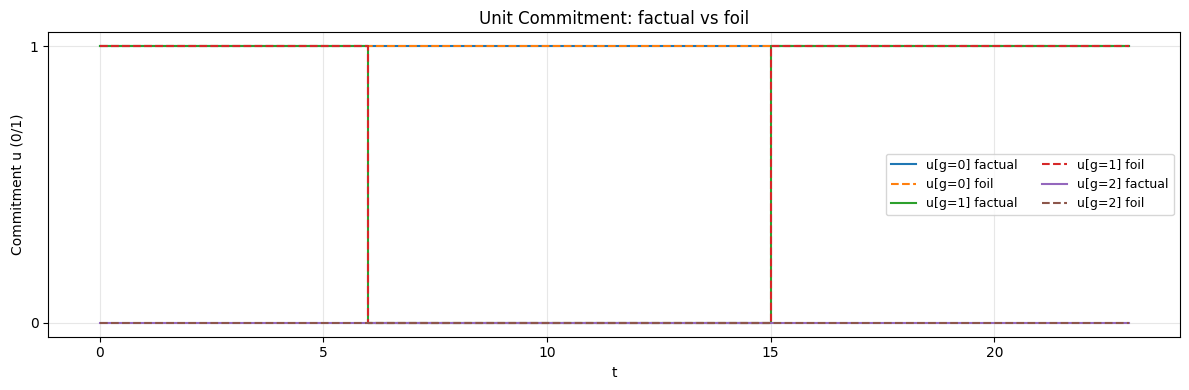

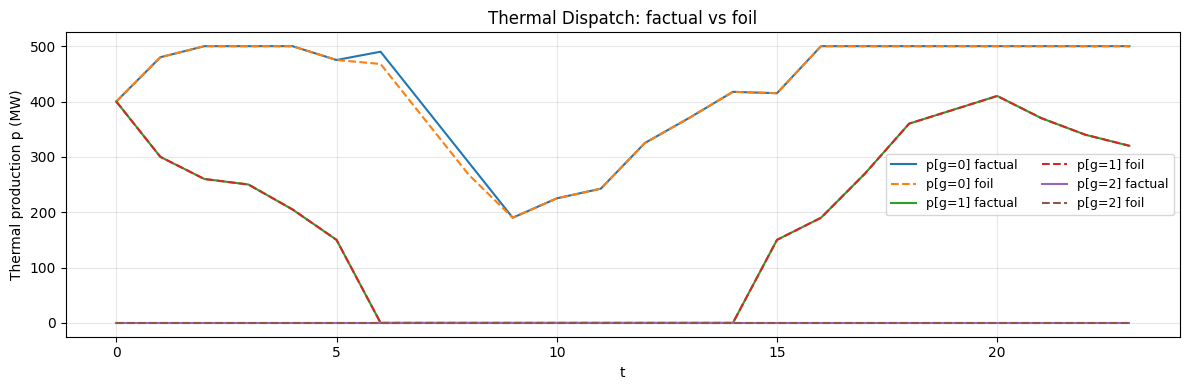

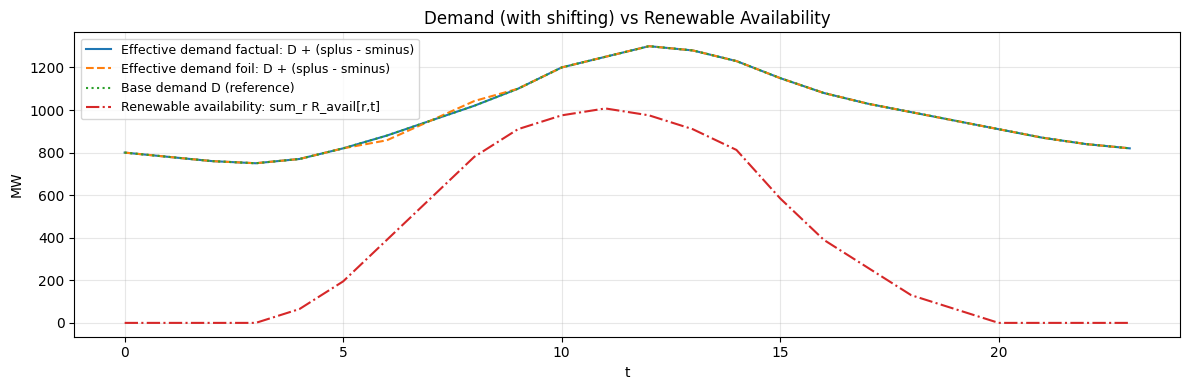

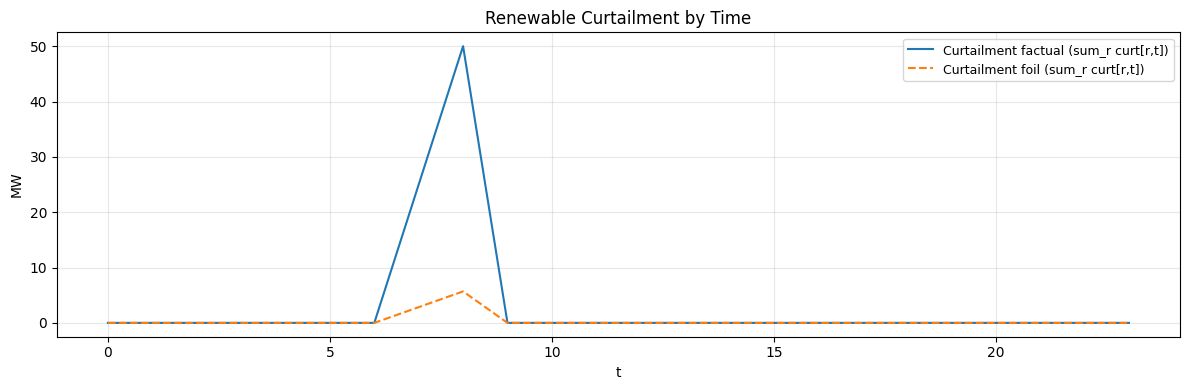

Total curtailment factual: 75.0
Total curtailment foil   : 8.533656717111853


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you already have ren_fact/ren_foil from extract_uc_solution_tables, use them
if ("ren_fact" in globals()) and (ren_fact is not None) and ("ren_foil" in globals()) and (ren_foil is not None):
    df_ren_compare = ren_fact.merge(
        ren_foil, on=["r", "t"], suffixes=("_fact", "_foil"), how="inner"
    )
    df_ren_compare["dpR_MW"]   = df_ren_compare["pR_MW_foil"]   - df_ren_compare["pR_MW_fact"]
    df_ren_compare["dcurt_MW"] = df_ren_compare["curt_MW_foil"] - df_ren_compare["curt_MW_fact"]

else:
    # Otherwise, reconstruct ren tables from x vectors (requires index_map_B3, nR, nT)
    def _slice_block(x, idxs):
        return np.array([x[i] for i in idxs], dtype=float)

    def _reshape_RT(block, nR, nT):
        return block.reshape(nR, nT)

    # Build ren_fact/ren_foil from x_factual_B3, x_foil_B3
    pR_fact   = _reshape_RT(_slice_block(x_factual_B3, index_map_B3["pR"]),   nR, nT)
    curt_fact = _reshape_RT(_slice_block(x_factual_B3, index_map_B3["curt"]), nR, nT)
    pR_foil   = _reshape_RT(_slice_block(x_foil_B3,   index_map_B3["pR"]),    nR, nT)
    curt_foil = _reshape_RT(_slice_block(x_foil_B3,   index_map_B3["curt"]),  nR, nT)

    ridx = pd.MultiIndex.from_product([range(nR), range(nT)], names=["r", "t"])
    ren_fact = pd.DataFrame({"pR_MW": pR_fact.reshape(-1), "curt_MW": curt_fact.reshape(-1)}, index=ridx).reset_index()
    ren_foil = pd.DataFrame({"pR_MW": pR_foil.reshape(-1), "curt_MW": curt_foil.reshape(-1)}, index=ridx).reset_index()

    df_ren_compare = ren_fact.merge(
        ren_foil, on=["r", "t"], suffixes=("_fact", "_foil"), how="inner"
    )
    df_ren_compare["dpR_MW"]   = df_ren_compare["pR_MW_foil"]   - df_ren_compare["pR_MW_fact"]
    df_ren_compare["dcurt_MW"] = df_ren_compare["curt_MW_foil"] - df_ren_compare["curt_MW_fact"]

print("df_ren_compare shape:", df_ren_compare.shape)
display(df_ren_compare.head())

# --------------------------
# 0) Sort (recommended)
# --------------------------
df_uc_compare = df_uc_compare.sort_values(["t", "g"]).reset_index(drop=True)
df_s_compare  = df_s_compare.sort_values(["t"]).reset_index(drop=True)

# --------------------------
# 1) Robust column picking (in case you changed names)
# --------------------------
def _pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns found: {candidates}")

t_col = _pick(df_uc_compare, ["t"])
g_col = _pick(df_uc_compare, ["g"])

u_fact_col = _pick(df_uc_compare, ["u_fact"])
u_foil_col = _pick(df_uc_compare, ["u_foil"])

p_fact_col = _pick(df_uc_compare, ["p_fact", "p_MW_fact"])
p_foil_col = _pick(df_uc_compare, ["p_foil", "p_MW_foil"])

snet_fact_col = _pick(df_s_compare, ["snet_fact", "snet_MW_fact"])
snet_foil_col = _pick(df_s_compare, ["snet_foil", "snet_MW_foil"])

# --------------------------
# 2) Pivot to (t x g) matrices
# --------------------------
u_fact = df_uc_compare.pivot(index=t_col, columns=g_col, values=u_fact_col).sort_index()
u_foil = df_uc_compare.pivot(index=t_col, columns=g_col, values=u_foil_col).sort_index()
p_fact = df_uc_compare.pivot(index=t_col, columns=g_col, values=p_fact_col).sort_index()
p_foil = df_uc_compare.pivot(index=t_col, columns=g_col, values=p_foil_col).sort_index()

t = u_fact.index.to_numpy()

# --------------------------
# FIGURE 1: Unit commitment u (factual vs foil)
# --------------------------
plt.figure(figsize=(12, 4))
for g in u_fact.columns:
    plt.step(t, u_fact[g].to_numpy(), where="post", label=f"u[g={g}] factual")
    plt.step(t, u_foil[g].to_numpy(), where="post", linestyle="--", label=f"u[g={g}] foil")
plt.yticks([0, 1])
plt.xlabel("t")
plt.ylabel("Commitment u (0/1)")
plt.title("Unit Commitment: factual vs foil")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# FIGURE 2: Production p (factual vs foil)
# --------------------------
plt.figure(figsize=(12, 4))
for g in p_fact.columns:
    plt.plot(t, p_fact[g].to_numpy(), label=f"p[g={g}] factual")
    plt.plot(t, p_foil[g].to_numpy(), linestyle="--", label=f"p[g={g}] foil")
plt.xlabel("t")
plt.ylabel("Thermal production p (MW)")
plt.title("Thermal Dispatch: factual vs foil")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# FIGURE 3: Effective demand (D + splus - sminus) factual vs foil
# --------------------------

D_arr = np.asarray(D, dtype=float).reshape(-1)

snet_fact = df_s_compare[snet_fact_col].to_numpy(dtype=float)
snet_foil = df_s_compare[snet_foil_col].to_numpy(dtype=float)

D_eff_fact = D_arr + snet_fact
D_eff_foil = D_arr + snet_foil

# Total renewable availability per time
R_avail_tot = np.sum(np.asarray(R_avail, dtype=float), axis=0)   # shape (nT,)

plt.figure(figsize=(12, 4))
plt.plot(t, D_eff_fact, label="Effective demand factual: D + (splus - sminus)")
plt.plot(t, D_eff_foil, linestyle="--", label="Effective demand foil: D + (splus - sminus)")
plt.plot(t, D_arr, linestyle=":", label="Base demand D (reference)")
plt.plot(t, R_avail_tot, linestyle="-.", label="Renewable availability: sum_r R_avail[r,t]")

plt.xlabel("t")
plt.ylabel("MW")
plt.title("Demand (with shifting) vs Renewable Availability")
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Aggregate over renewables r to get total curtailment at each time t
curt_t = (
    df_ren_compare
    .groupby("t")[["curt_MW_fact", "curt_MW_foil"]]
    .sum()
    .reset_index()
)

t = curt_t["t"].to_numpy(dtype=int)
curt_fact_t = curt_t["curt_MW_fact"].to_numpy(dtype=float)
curt_foil_t = curt_t["curt_MW_foil"].to_numpy(dtype=float)

plt.figure(figsize=(12, 4))
plt.plot(t, curt_fact_t, label="Curtailment factual (sum_r curt[r,t])")
plt.plot(t, curt_foil_t, linestyle="--", label="Curtailment foil (sum_r curt[r,t])")
plt.xlabel("t")
plt.ylabel("MW")
plt.title("Renewable Curtailment by Time")
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: quick totals sanity
print("Total curtailment factual:", float(np.sum(curt_fact_t)))
print("Total curtailment foil   :", float(np.sum(curt_foil_t)))

# E) Robust / stress-test counterfactuals (multi-scenario)

In [25]:
def make_demand_scenarios(D, deltas=(-0.10, 0.0, +0.10)):
    D = np.asarray(D, dtype=float)
    scenarios = []
    for d in deltas:
        scenarios.append((1.0 + d) * D)
    return np.stack(scenarios, axis=0)  # shape (S, T)

D_scen = make_demand_scenarios(D, deltas=(-0.10, 0.0, +0.10))
S = D_scen.shape[0]
weights = np.ones(S)/S  # equal weights
print("Scenario count S =", S, "| D_scen shape:", D_scen.shape)


Scenario count S = 3 | D_scen shape: (3, 24)


In [26]:
def precompute_index_map_robust(nG: int, nT: int, nR: int, S: int) -> Dict[str, List[int]]:
    idx = 0
    index_map: Dict[str, List[int]] = {}
    def take(name: str, k: int):
        nonlocal idx
        index_map[name] = list(range(idx, idx + k))
        idx += k

    # scenario-dependent dispatch p[g,t,s]
    take("p",     S * nG * nT)

    # shared commitment logic
    take("v",     nG * nT)
    take("w",     nG * nT)
    take("u",     nG * nT)

    # scenario-dependent renewable use/curt
    take("pR",    S * nR * nT)
    take("curt",  S * nR * nT)

    # shared shifting plan
    take("splus", nT)
    take("sminus",nT)

    return index_map


In [27]:
Vector = List[float]
ForwardBuilder = Callable[[gp.Model], Tuple[List[gp.Var], List[str]]]

def build_uc_forward_builder_robust(
    D_scen: np.ndarray,                 # (S, T)
    weights: np.ndarray,                # (S,)
    R_avail: np.ndarray,                # (nR, T)
    Pmin: Sequence[float], Pmax: Sequence[float],
    RU: Sequence[float], RD: Sequence[float],
    UT: Sequence[int], DT: Sequence[int],
    u_init: Sequence[int], p_init: Sequence[float],
    on_time_init: Sequence[int], off_time_init: Sequence[int],
    Splus_max: Sequence[float], Sminus_max: Sequence[float],
    window_size: Optional[int] = None,  # None=>global neutrality; int=>windowed
    use_vw_ramping: bool = True,
    SU_ramp: Optional[Sequence[float]] = None,
    SD_ramp: Optional[Sequence[float]] = None,
) -> Tuple[ForwardBuilder, Dict[str, List[int]]]:

    D_scen = np.asarray(D_scen, dtype=float)
    weights = np.asarray(weights, dtype=float)
    S = int(D_scen.shape[0])
    nT = int(D_scen.shape[1])

    nR, nT2 = R_avail.shape
    assert nT2 == nT
    nG = len(Pmin)

    index_map = precompute_index_map_robust(nG, nT, nR, S)

    if SU_ramp is None: SU_ramp = list(Pmax)
    if SD_ramp is None: SD_ramp = list(Pmax)

    W = None if window_size is None else int(window_size)
    if W is not None and W <= 0:
        raise ValueError("window_size must be positive or None")

    def forward_builder(m: gp.Model) -> Tuple[List[gp.Var], List[str]]:
        G = range(nG); R = range(nR); T = range(nT); Sc = range(S)

        # Shared UC
        u = m.addVars(G, T, vtype=GRB.BINARY, name="u")
        v = m.addVars(G, T, vtype=GRB.BINARY, name="v")
        w = m.addVars(G, T, vtype=GRB.BINARY, name="w")

        # Shared shifting plan
        splus  = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="splus")
        sminus = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="sminus")

        # Scenario-dependent recourse
        p    = m.addVars(Sc, G, T, lb=0.0, vtype=GRB.CONTINUOUS, name="p")     # p[s,g,t]
        pR   = m.addVars(Sc, R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="pR")    # pR[s,r,t]
        curt = m.addVars(Sc, R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="curt")  # curt[s,r,t]

        # ---------------------
        # Constraints
        # ---------------------

        # Shift bounds
        for t in T:
            m.addConstr(splus[t]  <= float(Splus_max[t]),  name=f"splus_max[{t}]")
            m.addConstr(sminus[t] <= float(Sminus_max[t]), name=f"sminus_max[{t}]")

        # Neutrality (shared shifting plan)
        if W is None:
            m.addConstr(gp.quicksum(splus[t] for t in T) == gp.quicksum(sminus[t] for t in T),
                        name="shift_neutrality_global")
        else:
            k = 0
            for start in range(0, nT, W):
                end = min(start + W, nT)
                m.addConstr(
                    gp.quicksum(splus[t] for t in range(start, end))
                    == gp.quicksum(sminus[t] for t in range(start, end)),
                    name=f"shift_neutrality_win[{k}]"
                )
                k += 1

        # Renewable availability (same R_avail in every scenario)
        for s in Sc:
            for r in R:
                for t in T:
                    m.addConstr(pR[s,r,t] + curt[s,r,t] == float(R_avail[r,t]),
                                name=f"ren_avail[{s},{r},{t}]")

        # Balance per scenario (shared shifting enters every scenario)
        for s in Sc:
            for t in T:
                m.addConstr(
                    gp.quicksum(p[s,g,t] for g in G) + gp.quicksum(pR[s,r,t] for r in R)
                    == float(D_scen[s,t]) + splus[t] - sminus[t],
                    name=f"balance[{s},{t}]"
                )

        # Capacity linking per scenario uses shared u
        for s in Sc:
            for g in G:
                for t in T:
                    m.addConstr(p[s,g,t] >= float(Pmin[g]) * u[g,t], name=f"pmin[{s},{g},{t}]")
                    m.addConstr(p[s,g,t] <= float(Pmax[g]) * u[g,t], name=f"pmax[{s},{g},{t}]")

        # UC transitions (shared)
        for g in G:
            m.addConstr(u[g,0] - int(u_init[g]) == v[g,0] - w[g,0], name=f"logic_init[{g}]")
            for t in range(1, nT):
                m.addConstr(u[g,t] - u[g,t-1] == v[g,t] - w[g,t], name=f"logic[{g},{t}]")
            for t in T:
                m.addConstr(v[g,t] + w[g,t] <= 1, name=f"no_simul[{g},{t}]")

        # Ramping per scenario (recommended v/w-aware)
        if not use_vw_ramping:
            for s in Sc:
                for g in G:
                    m.addConstr(p[s,g,0] - float(p_init[g]) <= float(RU[g]), name=f"ramp_up_init[{s},{g}]")
                    m.addConstr(float(p_init[g]) - p[s,g,0] <= float(RD[g]), name=f"ramp_dn_init[{s},{g}]")
                    for t in range(1, nT):
                        m.addConstr(p[s,g,t] - p[s,g,t-1] <= float(RU[g]), name=f"ramp_up[{s},{g},{t}]")
                        m.addConstr(p[s,g,t-1] - p[s,g,t] <= float(RD[g]), name=f"ramp_dn[{s},{g},{t}]")
        else:
            for s in Sc:
                for g in G:
                    m.addConstr(
                        p[s,g,0] - float(p_init[g])
                        <= float(RU[g]) * int(u_init[g]) + float(SU_ramp[g]) * v[g,0],
                        name=f"ramp_up_init[{s},{g}]"
                    )
                    m.addConstr(
                        float(p_init[g]) - p[s,g,0]
                        <= float(RD[g]) * u[g,0] + float(SD_ramp[g]) * w[g,0],
                        name=f"ramp_dn_init[{s},{g}]"
                    )
                    for t in range(1, nT):
                        m.addConstr(
                            p[s,g,t] - p[s,g,t-1]
                            <= float(RU[g]) * u[g,t-1] + float(SU_ramp[g]) * v[g,t],
                            name=f"ramp_up[{s},{g},{t}]"
                        )
                        m.addConstr(
                            p[s,g,t-1] - p[s,g,t]
                            <= float(RD[g]) * u[g,t] + float(SD_ramp[g]) * w[g,t],
                            name=f"ramp_dn[{s},{g},{t}]"
                        )

        # Min up/down + carryover (shared)
        for g in G:
            UTg = int(UT[g]); DTg = int(DT[g])

            if int(u_init[g]) == 1:
                rem_up = max(0, UTg - int(on_time_init[g]))
                for t in range(min(rem_up, nT)):
                    m.addConstr(u[g,t] == 1, name=f"carry_up[{g},{t}]")

            if int(u_init[g]) == 0:
                rem_dn = max(0, DTg - int(off_time_init[g]))
                for t in range(min(rem_dn, nT)):
                    m.addConstr(u[g,t] == 0, name=f"carry_dn[{g},{t}]")

            for t in T:
                start = max(0, t - UTg + 1)
                m.addConstr(gp.quicksum(v[g,tau] for tau in range(start, t+1)) <= u[g,t],
                            name=f"min_up[{g},{t}]")

            for t in T:
                start = max(0, t - DTg + 1)
                m.addConstr(gp.quicksum(w[g,tau] for tau in range(start, t+1)) <= 1 - u[g,t],
                            name=f"min_dn[{g},{t}]")

        # ---------------------
        # Output vector (must match index_map_robust)
        # ---------------------
        vars_out: List[gp.Var] = []
        names_out: List[str] = []

        # p (scenario-major, then g, then t)
        for s in range(S):
            for g in range(nG):
                for t in range(nT):
                    vars_out.append(p[s,g,t]); names_out.append(f"p[{s},{g},{t}]")

        # v,w,u (shared)
        for g in range(nG):
            for t in range(nT):
                vars_out.append(v[g,t]); names_out.append(f"v[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(w[g,t]); names_out.append(f"w[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(u[g,t]); names_out.append(f"u[{g},{t}]")

        # pR, curt (scenario-major)
        for s in range(S):
            for r in range(nR):
                for t in range(nT):
                    vars_out.append(pR[s,r,t]); names_out.append(f"pR[{s},{r},{t}]")
        for s in range(S):
            for r in range(nR):
                for t in range(nT):
                    vars_out.append(curt[s,r,t]); names_out.append(f"curt[{s},{r},{t}]")

        # shared splus/sminus
        for t in range(nT):
            vars_out.append(splus[t]); names_out.append(f"splus[{t}]")
        for t in range(nT):
            vars_out.append(sminus[t]); names_out.append(f"sminus[{t}]")

        return vars_out, names_out

    return forward_builder, index_map


In [28]:
def build_c_vector_robust(
    index_map: Dict[str, List[int]],
    nG: int, nT: int, nR: int, S: int,
    weights: np.ndarray,
    thermal_c: Sequence[float],
    SU_cost: Sequence[float],
    SD_cost: Sequence[float],
    pi_plus: Sequence[float],
    pi_minus: Sequence[float],
    kappa_curt: Optional[np.ndarray] = None,   # (nR,nT)
    pR_cost: float = 0.0,
    no_load_cost: Optional[Sequence[float]] = None,
) -> List[float]:

    if kappa_curt is None:
        kappa_curt = np.zeros((nR, nT), dtype=float)
    if no_load_cost is None:
        no_load_cost = [0.0]*nG

    n = max(max(v) for v in index_map.values()) + 1
    cvec = np.zeros(n, dtype=float)

    # p[s,g,t] coefficients: weight[s] * thermal_c[g]
    k = 0
    for s in range(S):
        for g in range(nG):
            for t in range(nT):
                cvec[index_map["p"][k]] = float(weights[s]) * float(thermal_c[g])
                k += 1

    # v,w,u (shared): no scenario weight (first-stage costs)
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["v"][k]] = float(SU_cost[g]); k += 1
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["w"][k]] = float(SD_cost[g]); k += 1
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["u"][k]] = float(no_load_cost[g]); k += 1

    # pR scenario-dependent (optional cost)
    for idx in index_map["pR"]:
        cvec[idx] = 0.0  # usually 0

    # curt[s,r,t] coefficients: weight[s] * kappa[r,t]
    k = 0
    for s in range(S):
        for r in range(nR):
            for t in range(nT):
                cvec[index_map["curt"][k]] = float(weights[s]) * float(kappa_curt[r,t])
                k += 1

    # shared splus/sminus coefficients: pi_plus[t], pi_minus[t]
    for t, idx in enumerate(index_map["splus"]):
        cvec[idx] = float(pi_plus[t])
    for t, idx in enumerate(index_map["sminus"]):
        cvec[idx] = float(pi_minus[t])

    return cvec.tolist()


In [29]:
def foil_total_curtailment_leq_all_scenarios(index_map, nR, nT, S, C_bar: float):
    curt_idxs = index_map["curt"]  # length S*nR*nT, scenario-major
    C_bar = float(C_bar)

    def foil_builder(m: gp.Model, vars_out, names_out):
        k = 0
        for s in range(S):
            expr = gp.LinExpr()
            for r in range(nR):
                for t in range(nT):
                    expr += vars_out[curt_idxs[k]]
                    k += 1
            m.addConstr(expr <= C_bar, name=f"foil_curt_leq[{s}]")
    return foil_builder


In [30]:
# Build robust forward builder
W = 6  # or None for global neutrality
forward_builder_E, index_map_E = build_uc_forward_builder_robust(
    D_scen=D_scen,
    weights=weights,
    R_avail=R_avail,
    Pmin=Pmin, Pmax=Pmax,
    RU=RU, RD=RD, UT=UT, DT=DT,
    u_init=u_init, p_init=p_init,
    on_time_init=on_time_init, off_time_init=off_time_init,
    Splus_max=Splus_max, Sminus_max=Sminus_max,
    window_size=W,
    use_vw_ramping=True,
    SU_ramp=Pmax, SD_ramp=Pmax
)

nG, nT = len(Pmin), len(D)
nR = R_avail.shape[0]
S = D_scen.shape[0]

# Baseline coefficients
c0_E = build_c_vector_robust(
    index_map=index_map_E,
    nG=nG, nT=nT, nR=nR, S=S,
    weights=weights,
    thermal_c=c,
    SU_cost=SU_cost,
    SD_cost=SD_cost,
    pi_plus=pi_plus,
    pi_minus=pi_minus,
    kappa_curt=kappa,
    pR_cost=0.0,
    no_load_cost=None
)

# Factual robust solve (expected cost, robust feasibility)
sp_status_E, x_factual_E, z_factual_E, _ = solve_forward_SP(forward_builder_E, c0_E, output_flag=0)
print("E factual SP:", sp_status_E, "obj=", z_factual_E)
assert sp_status_E == "OPTIMAL"

# Compute factual total curtailment per scenario
def curtailment_by_scenario(x_vec, index_map, nR, nT, S):
    x = np.asarray(x_vec, dtype=float)
    curt = x[index_map["curt"]].reshape(S, nR, nT)
    return curt.sum(axis=(1,2))  # shape (S,)

C_fact_s = curtailment_by_scenario(x_factual_E, index_map_E, nR, nT, S)
print("Factual curtailment per scenario:", C_fact_s, "| worst-case:", float(np.max(C_fact_s)))

# Set robust target (example: 80% of worst-case factual)
C_bar = 0.8 * float(np.max(C_fact_s))
print("Robust target C_bar (each scenario) =", C_bar)

foil_E = foil_total_curtailment_leq_all_scenarios(index_map_E, nR, nT, S, C_bar)

foil_ok = foil_feasibility_check(forward_builder_E, foil_E, output_flag=0)
print("Foil feasible?", foil_ok)
if not foil_ok:
    raise RuntimeError("Robust foil infeasible: relax C_bar or increase flexibility (shift bounds, etc.).")

# Domain: only shift costs mutable (shared splus/sminus still)
domain_E = build_domain_only_shift_mutable(
    c0_E, index_map_E,
    shift_lb=0.0,
    shift_ub=1e4
)

res_E = ncxplain(
    forward_builder=forward_builder_E,
    foil_builder=foil_E,
    c=c0_E,
    domain_d=domain_E,
    x_factual=x_factual_E,
    max_iters=200,
    tol=1e-7,
    mp_time_limit=120.0,
    sp_time_limit=60.0,
    output_flag=1
)

print("\n=== Robust E NCXplain result ===")
print("status:", res_E.status)
print("iters:", res_E.iters, "cuts_added:", res_E.cuts_added)


E factual SP: OPTIMAL obj= 340816.6666666667
Factual curtailment per scenario: [107.5  27.5  25.5] | worst-case: 107.5
Robust target C_bar (each scenario) = 86.0
Foil feasible? True
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  120
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 3223 rows, 2496 columns and 7456 nonzeros (Min)
Model fingerprint: 0x801a3a83
Model has 1248 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 2280 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  QMatrix range    [1e+00, 

In [31]:
x_foil_E = res_E.x_foil
C_foil_s = curtailment_by_scenario(x_foil_E, index_map_E, nR, nT, S)
print("Foil curtailment per scenario:", C_foil_s)
print("Check all <= C_bar:", np.all(C_foil_s <= C_bar + 1e-6))

Foil curtailment per scenario: [52. 25. 18.]
Check all <= C_bar: True


In [32]:
import numpy as np
import pandas as pd

# ============================================================
# Robust E: Extraction utilities (factual vs foil)
#   - Shift cost table (base vs d*)
#   - UC variables u,v,w (shared)
#   - Thermal production p (shared OR scenario-dependent)
#   - Renewables pR and curtailment curt (typically scenario-dependent)
#   - Shifts splus/sminus/snet (shared)
#   - Scenario curtailment totals + weighted expected curtailment
#   - Save everything to CSV
# ============================================================

def _slice_block(x, idxs):
    x = np.asarray(x, dtype=float)
    return x[np.asarray(idxs, dtype=int)]

def _reshape(block, *shape):
    return np.asarray(block, dtype=float).reshape(*shape)

def _clip_nonneg(a, tol=1e-6):
    a = np.asarray(a, dtype=float)
    a[np.abs(a) <= tol] = 0.0
    return np.maximum(a, 0.0)

def _round_bin(a):
    return np.rint(np.asarray(a, dtype=float)).astype(int)

def shift_cost_table(base_c, d_star, index_map, nT):
    """Works for both deterministic and robust if splus/sminus are shared (nT)."""
    base_c = np.asarray(base_c, dtype=float)
    d_star = np.asarray(d_star, dtype=float)

    splus_idx  = index_map["splus"]
    sminus_idx = index_map["sminus"]

    pi_plus_base  = base_c[splus_idx]
    pi_plus_foil  = d_star[splus_idx]
    pi_minus_base = base_c[sminus_idx]
    pi_minus_foil = d_star[sminus_idx]

    df = pd.DataFrame({
        "t": np.arange(nT, dtype=int),
        "pi_plus_base":  pi_plus_base,
        "pi_plus_foil":  pi_plus_foil,
        "delta_plus":    pi_plus_foil - pi_plus_base,
        "pi_minus_base": pi_minus_base,
        "pi_minus_foil": pi_minus_foil,
        "delta_minus":   pi_minus_foil - pi_minus_base,
    })
    return df

def extract_robust_solution_tables(
    x_vec,
    index_map,
    nG, nT, nR, S,
    weights=None,
    D_scen=None,               # shape (S,nT) optional (for effective demand tables)
    clip_tol=1e-6
):
    """
    Returns a dict of DataFrames + arrays that works whether p and pR/curt are
    shared or replicated per scenario.

    Assumptions:
      - u,v,w are shared blocks of length nG*nT
      - splus/sminus are shared blocks of length nT
      - p, pR, curt may be either shared (nG*nT / nR*nT) OR scenario-dependent
        (S*nG*nT / S*nR*nT).
    """
    x = np.asarray(x_vec, dtype=float)

    # --- shared UC blocks ---
    u = _reshape(_slice_block(x, index_map["u"]), nG, nT)
    v = _reshape(_slice_block(x, index_map["v"]), nG, nT)
    w = _reshape(_slice_block(x, index_map["w"]), nG, nT)

    u_int, v_int, w_int = _round_bin(u), _round_bin(v), _round_bin(w)

    # --- shifts (shared) ---
    splus  = _slice_block(x, index_map["splus"])
    sminus = _slice_block(x, index_map["sminus"])
    splus  = _clip_nonneg(splus,  tol=clip_tol)
    sminus = _clip_nonneg(sminus, tol=clip_tol)
    snet   = splus - sminus

    # --- thermal production p (shared OR scenario-dependent) ---
    p_block = _slice_block(x, index_map["p"])
    if len(p_block) == nG * nT:
        p = _reshape(p_block, nG, nT)
        p_is_scenario = False
    elif len(p_block) == S * nG * nT:
        p = _reshape(p_block, S, nG, nT)
        p_is_scenario = True
    else:
        raise ValueError(f"Unexpected len(p)={len(p_block)}; expected {nG*nT} or {S*nG*nT}")

    # --- renewables and curtailment (shared OR scenario-dependent) ---
    pR_block   = _slice_block(x, index_map["pR"])   if "pR" in index_map else None
    curt_block = _slice_block(x, index_map["curt"]) if "curt" in index_map else None

    pR = None
    curt = None
    ren_is_scenario = None

    if pR_block is not None and curt_block is not None:
        if len(pR_block) == nR * nT and len(curt_block) == nR * nT:
            pR   = _reshape(pR_block, nR, nT)
            curt = _reshape(curt_block, nR, nT)
            ren_is_scenario = False
        elif len(pR_block) == S * nR * nT and len(curt_block) == S * nR * nT:
            pR   = _reshape(pR_block, S, nR, nT)
            curt = _reshape(curt_block, S, nR, nT)
            ren_is_scenario = True
        else:
            raise ValueError(
                f"Unexpected len(pR)={len(pR_block)} / len(curt)={len(curt_block)}; "
                f"expected {nR*nT} or {S*nR*nT}"
            )

        curt = _clip_nonneg(curt, tol=clip_tol)

    # --------------------------
    # DataFrames
    # --------------------------

    # UC shared (g,t)
    uc_idx = pd.MultiIndex.from_product([range(nG), range(nT)], names=["g", "t"])
    df_uc = pd.DataFrame({
        "u": u_int.reshape(-1),
        "v": v_int.reshape(-1),
        "w": w_int.reshape(-1),
    }, index=uc_idx).reset_index()

    # Thermal dispatch
    if not p_is_scenario:
        df_p = pd.DataFrame({
            "g": np.repeat(np.arange(nG), nT),
            "t": np.tile(np.arange(nT), nG),
            "p_MW": p.reshape(-1),
        }).sort_values(["t","g"]).reset_index(drop=True)
    else:
        df_p = pd.DataFrame({
            "s": np.repeat(np.arange(S), nG*nT),
            "g": np.tile(np.repeat(np.arange(nG), nT), S),
            "t": np.tile(np.tile(np.arange(nT), nG), S),
            "p_MW": p.reshape(-1),
        }).sort_values(["s","t","g"]).reset_index(drop=True)

    # Shifts (t)
    df_s = pd.DataFrame({
        "t": np.arange(nT, dtype=int),
        "splus_MW": splus,
        "sminus_MW": sminus,
        "snet_MW": snet
    })

    # Effective demand per scenario (optional)
    df_dem = None
    if D_scen is not None:
        D_scen = np.asarray(D_scen, dtype=float)
        assert D_scen.shape == (S, nT)
        # Same snet applied to every scenario because splus/sminus are shared
        D_eff = D_scen + snet.reshape(1, -1)
        df_dem = pd.DataFrame({
            "s": np.repeat(np.arange(S), nT),
            "t": np.tile(np.arange(nT), S),
            "D_base": D_scen.reshape(-1),
            "snet": np.tile(snet, S),
            "D_eff": D_eff.reshape(-1)
        }).sort_values(["s","t"]).reset_index(drop=True)

    # Renewables & curtailment
    df_ren = None
    if pR is not None and curt is not None:
        if not ren_is_scenario:
            df_ren = pd.DataFrame({
                "r": np.repeat(np.arange(nR), nT),
                "t": np.tile(np.arange(nT), nR),
                "pR_MW": pR.reshape(-1),
                "curt_MW": curt.reshape(-1),
            }).sort_values(["t","r"]).reset_index(drop=True)
        else:
            df_ren = pd.DataFrame({
                "s": np.repeat(np.arange(S), nR*nT),
                "r": np.tile(np.repeat(np.arange(nR), nT), S),
                "t": np.tile(np.tile(np.arange(nT), nR), S),
                "pR_MW": pR.reshape(-1),
                "curt_MW": curt.reshape(-1),
            }).sort_values(["s","t","r"]).reset_index(drop=True)

    # Curtailment totals per scenario (if scenario-dependent)
    df_curt_s = None
    if curt is not None:
        if ren_is_scenario:
            C_s = curt.sum(axis=(1,2))  # (S,)
            df_curt_s = pd.DataFrame({"s": np.arange(S, dtype=int), "C_curt_MW": C_s})
            if weights is not None:
                w = np.asarray(weights, dtype=float).reshape(-1)
                df_curt_s["weight"] = w
                df_curt_s["weighted_C"] = df_curt_s["C_curt_MW"] * df_curt_s["weight"]
                df_curt_s.loc["TOTAL","C_curt_MW"] = df_curt_s["C_curt_MW"].sum()
                df_curt_s.loc["TOTAL","weighted_C"] = df_curt_s["weighted_C"].sum()
        else:
            C_tot = float(np.sum(curt))
            df_curt_s = pd.DataFrame({"C_curt_total_MW": [C_tot]})

    return {
        "df_uc": df_uc,
        "df_p": df_p,
        "df_s": df_s,
        "df_dem": df_dem,
        "df_ren": df_ren,
        "df_curt_s": df_curt_s,
        "arrays": {
            "u": u_int, "v": v_int, "w": w_int,
            "p": p, "p_is_scenario": p_is_scenario,
            "pR": pR, "curt": curt, "ren_is_scenario": ren_is_scenario,
            "splus": splus, "sminus": sminus, "snet": snet
        }
    }

def compare_shared_uc(df_uc_fact, df_uc_foil):
    """Compare u,v,w (shared) factual vs foil."""
    f = df_uc_fact.rename(columns={"u":"u_fact","v":"v_fact","w":"w_fact"})
    q = df_uc_foil.rename(columns={"u":"u_foil","v":"v_foil","w":"w_foil"})
    df = f.merge(q, on=["g","t"], how="inner")
    df["du"] = df["u_foil"] - df["u_fact"]
    df["dv"] = df["v_foil"] - df["v_fact"]
    df["dw"] = df["w_foil"] - df["w_fact"]
    return df.sort_values(["t","g"]).reset_index(drop=True)

def compare_shifts(df_s_fact, df_s_foil):
    f = df_s_fact.rename(columns={"splus_MW":"splus_fact","sminus_MW":"sminus_fact","snet_MW":"snet_fact"})
    q = df_s_foil.rename(columns={"splus_MW":"splus_foil","sminus_MW":"sminus_foil","snet_MW":"snet_foil"})
    df = f.merge(q, on=["t"], how="inner")
    df["dsplus"]  = df["splus_foil"]  - df["splus_fact"]
    df["dsminus"] = df["sminus_foil"] - df["sminus_fact"]
    df["dsnet"]   = df["snet_foil"]   - df["snet_fact"]
    return df.sort_values(["t"]).reset_index(drop=True)

# ============================================================
# RUN EXTRACTION FOR E (factual vs foil)
# ============================================================

# --- safety checks ---
if res_E.status != "OPTIMAL" or res_E.d_star is None or res_E.x_foil is None:
    raise RuntimeError(f"E did not solve to OPTIMAL. Status={res_E.status}")

d_star_E = res_E.d_star
x_foil_E = res_E.x_foil

# 1) Shift costs (base vs foil d*)
df_costs_E = shift_cost_table(c0_E, d_star_E, index_map_E, nT=nT)
display(df_costs_E)

print("Max |delta_plus| :", float(np.max(np.abs(df_costs_E["delta_plus"]))))
print("Max |delta_minus|:", float(np.max(np.abs(df_costs_E["delta_minus"]))))

# 2) Extract tables from factual and foil solutions
out_fact = extract_robust_solution_tables(
    x_factual_E, index_map_E, nG=nG, nT=nT, nR=nR, S=S,
    weights=weights, D_scen=D_scen
)
out_foil = extract_robust_solution_tables(
    x_foil_E, index_map_E, nG=nG, nT=nT, nR=nR, S=S,
    weights=weights, D_scen=D_scen
)

# 3) Comparisons (shared UC + shifts)
df_uc_compare_E = compare_shared_uc(out_fact["df_uc"], out_foil["df_uc"])
df_s_compare_E  = compare_shifts(out_fact["df_s"], out_foil["df_s"])

display(df_uc_compare_E.head(24))
display(df_s_compare_E)

# 4) Scenario curtailment check (robust foil requirement)
print("\nCurtailment totals per scenario (FACTUAL):")
display(out_fact["df_curt_s"])
print("\nCurtailment totals per scenario (FOIL):")
display(out_foil["df_curt_s"])

# If scenario-dependent curt exists, verify robust constraint:
if out_foil["arrays"]["ren_is_scenario"]:
    C_foil_s = out_foil["arrays"]["curt"].sum(axis=(1,2))
    print("C_foil_s:", C_foil_s)
    print("Check all <= C_bar:", bool(np.all(C_foil_s <= C_bar + 1e-6)))

# 5) Save everything to CSV
df_costs_E.to_csv("E_shift_costs_base_vs_foil.csv", index=False)
df_uc_compare_E.to_csv("E_uc_compare_shared.csv", index=False)
df_s_compare_E.to_csv("E_shifts_compare.csv", index=False)

out_fact["df_p"].to_csv("E_p_factual.csv", index=False)
out_foil["df_p"].to_csv("E_p_foil.csv", index=False)

if out_fact["df_dem"] is not None: out_fact["df_dem"].to_csv("E_demand_factual.csv", index=False)
if out_foil["df_dem"] is not None: out_foil["df_dem"].to_csv("E_demand_foil.csv", index=False)

if out_fact["df_ren"] is not None: out_fact["df_ren"].to_csv("E_ren_factual.csv", index=False)
if out_foil["df_ren"] is not None: out_foil["df_ren"].to_csv("E_ren_foil.csv", index=False)

if out_fact["df_curt_s"] is not None: out_fact["df_curt_s"].to_csv("E_curtailment_by_scenario_factual.csv", index=False)
if out_foil["df_curt_s"] is not None: out_foil["df_curt_s"].to_csv("E_curtailment_by_scenario_foil.csv", index=False)

print("Saved CSVs: E_shift_costs_base_vs_foil.csv, E_uc_compare_shared.csv, E_shifts_compare.csv, "
      "E_p_factual.csv, E_p_foil.csv, plus demand/renewable/scenario-curt files (if present).")


,t,pi_plus_base,pi_plus_foil,delta_plus,pi_minus_base,pi_minus_foil,delta_minus
0,0,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
1,1,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
2,2,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
3,3,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
4,4,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
5,5,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
6,6,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
7,7,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
8,8,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11
9,9,100.0,100.000000,-9.433165e-11,100.0,100.000000,-9.433165e-11


Max |delta_plus| : 72.61316872488082
Max |delta_minus|: 72.61316872488084


,g,t,u_fact,v_fact,w_fact,u_foil,v_foil,w_foil,du,dv,dw
0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,1,1,0,1,1,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,0,0,0,0,0
5,2,1,0,0,0,0,0,0,0,0,0
6,0,2,1,0,0,1,0,0,0,0,0
7,1,2,1,0,0,1,0,0,0,0,0
8,2,2,0,0,0,0,0,0,0,0,0
9,0,3,1,0,0,1,0,0,0,0,0


,t,splus_fact,sminus_fact,snet_fact,splus_foil,sminus_foil,snet_foil,dsplus,dsminus,dsnet
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Curtailment totals per scenario (FACTUAL):


,s,C_curt_MW,weight,weighted_C
0,0.0,107.5,0.333333,35.833333
1,1.0,27.5,0.333333,9.166667
2,2.0,25.5,0.333333,8.500000
TOTAL,NaN,160.5,NaN,53.500000



Curtailment totals per scenario (FOIL):


,s,C_curt_MW,weight,weighted_C
0,0.0,52.0,0.333333,17.333333
1,1.0,25.0,0.333333,8.333333
2,2.0,18.0,0.333333,6.000000
TOTAL,NaN,95.0,NaN,31.666667


C_foil_s: [52. 25. 18.]
Check all <= C_bar: True
Saved CSVs: E_shift_costs_base_vs_foil.csv, E_uc_compare_shared.csv, E_shifts_compare.csv, E_p_factual.csv, E_p_foil.csv, plus demand/renewable/scenario-curt files (if present).


## Commments on E)

The robust WCE modifies the shift-cost coefficients so that the optimal policy shifts 40.5 MW of load from hour 14 to hour 15 (and applies no shifting at other hours). Under this counterfactual pricing, the resulting weakly-optimal solution satisfies the robust foil constraint for all demand scenarios considered, i.e., total curtailment in each scenario is bounded by $\bar{C} = 0.8 \times C_{\text{max}^{\text{fact}}}$ (in this case $86$).

$C_{\text{foil}}^{{\text{S}}}$: $[52,25,18] \le 86$

## Bigger instances

In [33]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from typing import Sequence, Tuple, List, Dict, Callable, Optional

Vector = List[float]
ForwardBuilder = Callable[[gp.Model], Tuple[List[gp.Var], List[str]]]

# ============================================================
# 1) Scenario generation (time-varying, smoothed noise)
# ============================================================
def smooth_noise(T, scale=1.0, smooth_k=5, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    z = rng.normal(0.0, scale, size=T)
    # simple moving average smoothing
    k = int(smooth_k)
    if k <= 1:
        return z
    kernel = np.ones(k) / k
    return np.convolve(z, kernel, mode="same")

def make_scenarios_big(
    D_base, R_avail_base,
    S=20,
    demand_sigma=0.08,          # ~8% std per hour
    renew_sigma=0.15,           # ~15% std per hour
    smooth_k=5,
    seed=123
):
    rng = np.random.default_rng(seed)
    D_base = np.asarray(D_base, dtype=float)            # (T,)
    R_base = np.asarray(R_avail_base, dtype=float)      # (nR,T)
    nR, T = R_base.shape

    D_scen = np.zeros((S, T), dtype=float)
    R_scen = np.zeros((S, nR, T), dtype=float)

    for s in range(S):
        # demand multiplicative noise per hour
        epsD = smooth_noise(T, scale=demand_sigma, smooth_k=smooth_k, rng=rng)
        D_s = D_base * (1.0 + epsD)
        D_s = np.maximum(D_s, 0.0)  # no negative demand
        D_scen[s, :] = D_s

        # renew multiplicative noise per hour (per renewable unit)
        for r in range(nR):
            epsR = smooth_noise(T, scale=renew_sigma, smooth_k=smooth_k, rng=rng)
            R_sr = R_base[r, :] * (1.0 + epsR)
            R_sr = np.maximum(R_sr, 0.0)
            R_scen[s, r, :] = R_sr

    weights = np.ones(S) / S
    return D_scen, R_scen, weights

# Example usage:
S_big = 20
D_scen_big, R_scen_big, weights_big = make_scenarios_big(
    D_base=D,
    R_avail_base=R_avail,
    S=S_big,
    demand_sigma=0.08,
    renew_sigma=0.15,
    smooth_k=5,
    seed=123
)

print("D_scen_big:", D_scen_big.shape, "| R_scen_big:", R_scen_big.shape, "| weights:", weights_big.shape)


# ============================================================
# 2) Index map for robust model with scenario-renewables
# ============================================================
def precompute_index_map_robust_big(nG: int, nT: int, nR: int, S: int) -> Dict[str, List[int]]:
    idx = 0
    index_map: Dict[str, List[int]] = {}
    def take(name: str, k: int):
        nonlocal idx
        index_map[name] = list(range(idx, idx + k))
        idx += k

    # scenario-dependent dispatch
    take("p",     S * nG * nT)

    # shared UC
    take("v",     nG * nT)
    take("w",     nG * nT)
    take("u",     nG * nT)

    # scenario-dependent renewables and curtailment
    take("pR",    S * nR * nT)
    take("curt",  S * nR * nT)

    # shared shifting
    take("splus", nT)
    take("sminus",nT)

    return index_map


# ============================================================
# 3) Robust forward builder (demand + renewable scenarios)
# ============================================================
def build_uc_forward_builder_robust_big(
    D_scen: np.ndarray,                  # (S,T)
    R_avail_scen: np.ndarray,            # (S,nR,T)
    weights: np.ndarray,                 # (S,)
    Pmin: Sequence[float], Pmax: Sequence[float],
    RU: Sequence[float], RD: Sequence[float],
    UT: Sequence[int], DT: Sequence[int],
    u_init: Sequence[int], p_init: Sequence[float],
    on_time_init: Sequence[int], off_time_init: Sequence[int],
    Splus_max: Sequence[float], Sminus_max: Sequence[float],
    window_size: Optional[int] = 6,      # None => global, int => windowed
    use_vw_ramping: bool = True,
    SU_ramp: Optional[Sequence[float]] = None,
    SD_ramp: Optional[Sequence[float]] = None,
) -> Tuple[ForwardBuilder, Dict[str, List[int]]]:

    D_scen = np.asarray(D_scen, dtype=float)
    R_avail_scen = np.asarray(R_avail_scen, dtype=float)
    weights = np.asarray(weights, dtype=float)

    S = int(D_scen.shape[0])
    nT = int(D_scen.shape[1])
    S2, nR, nT2 = R_avail_scen.shape
    assert S2 == S and nT2 == nT

    nG = len(Pmin)

    index_map = precompute_index_map_robust_big(nG, nT, nR, S)

    if SU_ramp is None: SU_ramp = list(Pmax)
    if SD_ramp is None: SD_ramp = list(Pmax)

    W = None if window_size is None else int(window_size)
    if W is not None and W <= 0:
        raise ValueError("window_size must be positive or None")

    def forward_builder(m: gp.Model) -> Tuple[List[gp.Var], List[str]]:
        G = range(nG); R = range(nR); T = range(nT); Sc = range(S)

        # Shared UC
        u = m.addVars(G, T, vtype=GRB.BINARY, name="u")
        v = m.addVars(G, T, vtype=GRB.BINARY, name="v")
        w = m.addVars(G, T, vtype=GRB.BINARY, name="w")

        # Shared shifting
        splus  = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="splus")
        sminus = m.addVars(T, lb=0.0, vtype=GRB.CONTINUOUS, name="sminus")

        # Scenario recourse
        p    = m.addVars(Sc, G, T, lb=0.0, vtype=GRB.CONTINUOUS, name="p")
        pR   = m.addVars(Sc, R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="pR")
        curt = m.addVars(Sc, R, T, lb=0.0, vtype=GRB.CONTINUOUS, name="curt")

        # Shift bounds
        for t in T:
            m.addConstr(splus[t]  <= float(Splus_max[t]),  name=f"splus_max[{t}]")
            m.addConstr(sminus[t] <= float(Sminus_max[t]), name=f"sminus_max[{t}]")

        # Neutrality
        if W is None:
            m.addConstr(gp.quicksum(splus[t] for t in T) == gp.quicksum(sminus[t] for t in T),
                        name="shift_neutrality_global")
        else:
            k = 0
            for start in range(0, nT, W):
                end = min(start + W, nT)
                m.addConstr(
                    gp.quicksum(splus[t] for t in range(start, end))
                    == gp.quicksum(sminus[t] for t in range(start, end)),
                    name=f"shift_neutrality_win[{k}]"
                )
                k += 1

        # Renewable availability per scenario
        for s in Sc:
            for r in R:
                for t in T:
                    m.addConstr(pR[s,r,t] + curt[s,r,t] == float(R_avail_scen[s,r,t]),
                                name=f"ren_avail[{s},{r},{t}]")

        # Balance per scenario
        for s in Sc:
            for t in T:
                m.addConstr(
                    gp.quicksum(p[s,g,t] for g in G) + gp.quicksum(pR[s,r,t] for r in R)
                    == float(D_scen[s,t]) + splus[t] - sminus[t],
                    name=f"balance[{s},{t}]"
                )

        # Capacity link per scenario (shared u)
        for s in Sc:
            for g in G:
                for t in T:
                    m.addConstr(p[s,g,t] >= float(Pmin[g]) * u[g,t], name=f"pmin[{s},{g},{t}]")
                    m.addConstr(p[s,g,t] <= float(Pmax[g]) * u[g,t], name=f"pmax[{s},{g},{t}]")

        # UC transitions (shared)
        for g in G:
            m.addConstr(u[g,0] - int(u_init[g]) == v[g,0] - w[g,0], name=f"logic_init[{g}]")
            for t in range(1, nT):
                m.addConstr(u[g,t] - u[g,t-1] == v[g,t] - w[g,t], name=f"logic[{g},{t}]")
            for t in T:
                m.addConstr(v[g,t] + w[g,t] <= 1, name=f"no_simul[{g},{t}]")

        # Ramping per scenario (v/w-aware recommended)
        if not use_vw_ramping:
            for s in Sc:
                for g in G:
                    m.addConstr(p[s,g,0] - float(p_init[g]) <= float(RU[g]), name=f"ramp_up_init[{s},{g}]")
                    m.addConstr(float(p_init[g]) - p[s,g,0] <= float(RD[g]), name=f"ramp_dn_init[{s},{g}]")
                    for t in range(1, nT):
                        m.addConstr(p[s,g,t] - p[s,g,t-1] <= float(RU[g]), name=f"ramp_up[{s},{g},{t}]")
                        m.addConstr(p[s,g,t-1] - p[s,g,t] <= float(RD[g]), name=f"ramp_dn[{s},{g},{t}]")
        else:
            for s in Sc:
                for g in G:
                    m.addConstr(
                        p[s,g,0] - float(p_init[g])
                        <= float(RU[g]) * int(u_init[g]) + float(SU_ramp[g]) * v[g,0],
                        name=f"ramp_up_init[{s},{g}]"
                    )
                    m.addConstr(
                        float(p_init[g]) - p[s,g,0]
                        <= float(RD[g]) * u[g,0] + float(SD_ramp[g]) * w[g,0],
                        name=f"ramp_dn_init[{s},{g}]"
                    )
                    for t in range(1, nT):
                        m.addConstr(
                            p[s,g,t] - p[s,g,t-1]
                            <= float(RU[g]) * u[g,t-1] + float(SU_ramp[g]) * v[g,t],
                            name=f"ramp_up[{s},{g},{t}]"
                        )
                        m.addConstr(
                            p[s,g,t-1] - p[s,g,t]
                            <= float(RD[g]) * u[g,t] + float(SD_ramp[g]) * w[g,t],
                            name=f"ramp_dn[{s},{g},{t}]"
                        )

        # Min up/down + carryover (shared)
        for g in G:
            UTg = int(UT[g]); DTg = int(DT[g])

            if int(u_init[g]) == 1:
                rem_up = max(0, UTg - int(on_time_init[g]))
                for t in range(min(rem_up, nT)):
                    m.addConstr(u[g,t] == 1, name=f"carry_up[{g},{t}]")

            if int(u_init[g]) == 0:
                rem_dn = max(0, DTg - int(off_time_init[g]))
                for t in range(min(rem_dn, nT)):
                    m.addConstr(u[g,t] == 0, name=f"carry_dn[{g},{t}]")

            for t in T:
                start = max(0, t - UTg + 1)
                m.addConstr(gp.quicksum(v[g,tau] for tau in range(start, t+1)) <= u[g,t],
                            name=f"min_up[{g},{t}]")
            for t in T:
                start = max(0, t - DTg + 1)
                m.addConstr(gp.quicksum(w[g,tau] for tau in range(start, t+1)) <= 1 - u[g,t],
                            name=f"min_dn[{g},{t}]")

        # Output vector (must match index map)
        vars_out, names_out = [], []

        for s in range(S):
            for g in range(nG):
                for t in range(nT):
                    vars_out.append(p[s,g,t]); names_out.append(f"p[{s},{g},{t}]")

        for g in range(nG):
            for t in range(nT):
                vars_out.append(v[g,t]); names_out.append(f"v[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(w[g,t]); names_out.append(f"w[{g},{t}]")
        for g in range(nG):
            for t in range(nT):
                vars_out.append(u[g,t]); names_out.append(f"u[{g},{t}]")

        for s in range(S):
            for r in range(nR):
                for t in range(nT):
                    vars_out.append(pR[s,r,t]); names_out.append(f"pR[{s},{r},{t}]")
        for s in range(S):
            for r in range(nR):
                for t in range(nT):
                    vars_out.append(curt[s,r,t]); names_out.append(f"curt[{s},{r},{t}]")

        for t in range(nT):
            vars_out.append(splus[t]); names_out.append(f"splus[{t}]")
        for t in range(nT):
            vars_out.append(sminus[t]); names_out.append(f"sminus[{t}]")

        return vars_out, names_out

    return forward_builder, index_map


# ============================================================
# 4) Baseline coefficient vector (expected-cost)
# ============================================================
def build_c_vector_robust_big(
    index_map: Dict[str, List[int]],
    nG: int, nT: int, nR: int, S: int,
    weights: np.ndarray,
    thermal_c: Sequence[float],
    SU_cost: Sequence[float],
    SD_cost: Sequence[float],
    pi_plus: Sequence[float],
    pi_minus: Sequence[float],
    kappa_curt: Optional[np.ndarray] = None,   # (nR,nT)
) -> List[float]:

    if kappa_curt is None:
        kappa_curt = np.zeros((nR, nT), dtype=float)

    n = max(max(v) for v in index_map.values()) + 1
    cvec = np.zeros(n, dtype=float)

    # p[s,g,t] weighted
    k = 0
    for s in range(S):
        for g in range(nG):
            for t in range(nT):
                cvec[index_map["p"][k]] = float(weights[s]) * float(thermal_c[g])
                k += 1

    # v,w shared
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["v"][k]] = float(SU_cost[g]); k += 1
    k = 0
    for g in range(nG):
        for t in range(nT):
            cvec[index_map["w"][k]] = float(SD_cost[g]); k += 1

    # u has 0 cost here (optional)
    for idx in index_map["u"]:
        cvec[idx] = 0.0

    # pR has 0 cost
    for idx in index_map["pR"]:
        cvec[idx] = 0.0

    # curt weighted
    k = 0
    for s in range(S):
        for r in range(nR):
            for t in range(nT):
                cvec[index_map["curt"][k]] = float(weights[s]) * float(kappa_curt[r,t])
                k += 1

    # shifting costs shared
    for t, idx in enumerate(index_map["splus"]):
        cvec[idx] = float(pi_plus[t])
    for t, idx in enumerate(index_map["sminus"]):
        cvec[idx] = float(pi_minus[t])

    return cvec.tolist()


# ============================================================
# 5) Robust foil: curtailment cap in every scenario
# ============================================================
def curtailment_by_scenario_big(x_vec, index_map, nR, nT, S):
    x = np.asarray(x_vec, dtype=float)
    curt = x[index_map["curt"]].reshape(S, nR, nT)
    return curt.sum(axis=(1,2))

def foil_total_curtailment_leq_all_scenarios_big(index_map, nR, nT, S, C_bar):
    curt_idxs = index_map["curt"]
    C_bar = float(C_bar)
    def foil_builder(m: gp.Model, vars_out, names_out):
        k = 0
        for s in range(S):
            expr = gp.LinExpr()
            for r in range(nR):
                for t in range(nT):
                    expr += vars_out[curt_idxs[k]]
                    k += 1
            m.addConstr(expr <= C_bar, name=f"foil_curt_leq[{s}]")
    return foil_builder


# ============================================================
# 6) Run Bigger E+ (robust WCE)
# ============================================================
W = 6
forward_builder_Ebig, index_map_Ebig = build_uc_forward_builder_robust_big(
    D_scen=D_scen_big,
    R_avail_scen=R_scen_big,
    weights=weights_big,
    Pmin=Pmin, Pmax=Pmax,
    RU=RU, RD=RD, UT=UT, DT=DT,
    u_init=u_init, p_init=p_init,
    on_time_init=on_time_init, off_time_init=off_time_init,
    Splus_max=Splus_max, Sminus_max=Sminus_max,
    window_size=W,
    use_vw_ramping=True,
    SU_ramp=Pmax, SD_ramp=Pmax
)

nG, nT = len(Pmin), len(D)
nR = R_avail.shape[0]
S = D_scen_big.shape[0]

c0_Ebig = build_c_vector_robust_big(
    index_map=index_map_Ebig,
    nG=nG, nT=nT, nR=nR, S=S,
    weights=weights_big,
    thermal_c=c,
    SU_cost=SU_cost,
    SD_cost=SD_cost,
    pi_plus=pi_plus, pi_minus=pi_minus,
    kappa_curt=kappa
)

# Factual solve
sp_status, x_factual_Ebig, z_factual_Ebig, _ = solve_forward_SP(forward_builder_Ebig, c0_Ebig, output_flag=0)
print("E+ factual SP:", sp_status, "obj=", z_factual_Ebig)
assert sp_status == "OPTIMAL"

C_fact_s = curtailment_by_scenario_big(x_factual_Ebig, index_map_Ebig, nR, nT, S)
C_max = float(np.max(C_fact_s))
print("Worst-case factual curtailment:", C_max)

# Robust target: 80% of worst-case
C_bar = 0.5 * C_max
print("C_bar =", C_bar)

foil_Ebig = foil_total_curtailment_leq_all_scenarios_big(index_map_Ebig, nR, nT, S, C_bar)

foil_ok = foil_feasibility_check(forward_builder_Ebig, foil_Ebig, output_flag=0)
print("Foil feasible?", foil_ok)
if not foil_ok:
    raise RuntimeError("Foil infeasible: relax C_bar or increase flexibility.")

domain_Ebig = build_domain_only_shift_mutable(c0_Ebig, index_map_Ebig, shift_lb=0.0, shift_ub=1e4)

res_Ebig = ncxplain(
    forward_builder=forward_builder_Ebig,
    foil_builder=foil_Ebig,
    c=c0_Ebig,
    domain_d=domain_Ebig,
    x_factual=x_factual_Ebig,
    max_iters=200,
    tol=1e-7,
    mp_time_limit=240.0,   # larger instance => more time
    sp_time_limit=120.0,
    output_flag=1
)

print("\n=== Bigger Robust E+ NCXplain result ===")
print("status:", res_Ebig.status)
print("iters:", res_Ebig.iters, "cuts_added:", res_Ebig.cuts_added)

if res_Ebig.d_star is not None and res_Ebig.x_foil is not None:
    C_foil_s = curtailment_by_scenario_big(res_Ebig.x_foil, index_map_Ebig, nR, nT, S)
    print("Check all <= C_bar:", bool(np.all(C_foil_s <= C_bar + 1e-6)))
    print("Worst-case foil curtailment:", float(np.max(C_foil_s)))


D_scen_big: (20, 24) | R_scen_big: (20, 1, 24) | weights: (20,)
E+ factual SP: OPTIMAL obj= 342778.16624363273
Worst-case factual curtailment: 238.0442293447295
C_bar = 119.02211467236475
Foil feasible? True
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 240
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  240
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 15072 rows, 10656 columns and 35863 nonzeros (Min)
Model fingerprint: 0x56a95eb1
Model has 5328 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 10440 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+0

In [34]:
from dataclasses import dataclass
from typing import Optional, List, Sequence, Tuple

@dataclass
class NCXplainResult:
    status: str
    d_star: Optional[List[float]] = None
    x_foil: Optional[List[float]] = None
    iters: int = 0
    cuts_added: int = 0
    best_l1: Optional[float] = None
    last_violation: Optional[float] = None  # d·x_foil - d·x_opt

def ncxplain_best_effort(
    forward_builder,
    foil_builder,
    c: Sequence[float],
    domain_d,
    x_factual: List[float],
    max_iters: int = 200,
    tol: float = 1e-7,
    mp_time_limit: Optional[float] = None,
    sp_time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> NCXplainResult:

    S0: List[List[float]] = [list(x_factual)]
    cuts_added = 0

    best_d = None
    best_x = None
    best_l1 = None
    last_violation = None

    for it in range(1, max_iters + 1):
        mp_status, d_i, x_i, mp_obj, var_names = solve_master_MPNCE(
            forward_builder, foil_builder, c, domain_d, S0,
            time_limit=mp_time_limit, output_flag=output_flag
        )

        # If MP found an incumbent, d_i and x_i are meaningful
        if mp_status in ("OPTIMAL", "TIME_LIMIT"):
            if best_l1 is None or mp_obj < best_l1:
                best_l1 = mp_obj
                best_d = list(d_i)
                best_x = list(x_i)
        else:
            return NCXplainResult(status=mp_status, iters=it, cuts_added=cuts_added,
                                  d_star=best_d, x_foil=best_x, best_l1=best_l1,
                                  last_violation=last_violation)

        # Verify with SP under d_i
        sp_status, x0_i, sp_obj, _ = solve_forward_SP(
            forward_builder, d_i, time_limit=sp_time_limit, output_flag=0
        )
        if sp_status != "OPTIMAL":
            return NCXplainResult(status=f"SP_{sp_status}", iters=it, cuts_added=cuts_added,
                                  d_star=best_d, x_foil=best_x, best_l1=best_l1,
                                  last_violation=last_violation)

        di_xi = dot(d_i, x_i)
        di_x0 = dot(d_i, x0_i)
        last_violation = float(di_xi - di_x0)

        if output_flag:
            print(f"[iter {it}] MP({mp_status}) ||d-c||1={mp_obj:.6g}  "
                  f"d·x_foil={di_xi:.6g}  d·x_opt={di_x0:.6g}  viol={last_violation:.6g}")

        # Converged: weak optimality achieved
        if abs(di_xi - di_x0) <= tol * (1.0 + max(abs(di_xi), abs(di_x0))):
            return NCXplainResult(status="OPTIMAL", d_star=d_i, x_foil=x_i, iters=it,
                                  cuts_added=cuts_added, best_l1=mp_obj, last_violation=last_violation)

        # Otherwise, add cut and continue
        S0.append(list(x0_i))
        cuts_added += 1

    # Not converged: return best-so-far incumbent
    return NCXplainResult(status="BEST_EFFORT", d_star=best_d, x_foil=best_x, iters=max_iters,
                          cuts_added=cuts_added, best_l1=best_l1, last_violation=last_violation)


In [35]:
import numpy as np
import pandas as pd

def extract_robust_big(x, index_map, nG, nT, nR, S, clip_tol=1e-6):
    x = np.asarray(x, dtype=float)

    p = x[index_map["p"]].reshape(S, nG, nT)

    v = x[index_map["v"]].reshape(nG, nT)
    w = x[index_map["w"]].reshape(nG, nT)
    u = x[index_map["u"]].reshape(nG, nT)
    u = np.rint(u).astype(int)
    v = np.rint(v).astype(int)
    w = np.rint(w).astype(int)

    pR   = x[index_map["pR"]].reshape(S, nR, nT)
    curt = x[index_map["curt"]].reshape(S, nR, nT)

    splus  = x[index_map["splus"]].copy()
    sminus = x[index_map["sminus"]].copy()

    # cleanup
    curt = np.where(np.abs(curt) <= clip_tol, 0.0, curt)
    curt = np.maximum(curt, 0.0)

    splus  = np.where(np.abs(splus)  <= clip_tol, 0.0, splus)
    sminus = np.where(np.abs(sminus) <= clip_tol, 0.0, sminus)
    splus  = np.maximum(splus, 0.0)
    sminus = np.maximum(sminus, 0.0)
    snet = splus - sminus

    # UC table (shared)
    uc_rows = []
    for g in range(nG):
        for t in range(nT):
            uc_rows.append([g, t, u[g,t], v[g,t], w[g,t]])
    df_uc = pd.DataFrame(uc_rows, columns=["g","t","u","v","w"])

    # Shift table (shared)
    df_s = pd.DataFrame({
        "t": np.arange(nT, dtype=int),
        "splus": splus,
        "sminus": sminus,
        "snet": snet,
    })

    # Curtailment by scenario
    C_s = curt.sum(axis=(1,2))
    df_curt_s = pd.DataFrame({
        "s": np.arange(S, dtype=int),
        "C_curt_total": C_s
    })

    # Identify worst scenario
    s_worst = int(np.argmax(C_s))

    # Dispatch tables for a chosen scenario (default: worst)
    def scenario_tables(s_idx):
        df_p = pd.DataFrame(
            [(s_idx, g, t, p[s_idx,g,t]) for g in range(nG) for t in range(nT)],
            columns=["s","g","t","p_MW"]
        )
        df_ren = pd.DataFrame(
            [(s_idx, r, t, pR[s_idx,r,t], curt[s_idx,r,t]) for r in range(nR) for t in range(nT)],
            columns=["s","r","t","pR_MW","curt_MW"]
        )
        return df_p, df_ren

    df_p_worst, df_ren_worst = scenario_tables(s_worst)

    return {
        "p": p, "pR": pR, "curt": curt,
        "u": u, "v": v, "w": w,
        "splus": splus, "sminus": sminus, "snet": snet,
        "df_uc": df_uc,
        "df_s": df_s,
        "df_curt_s": df_curt_s,
        "s_worst": s_worst,
        "df_p_worst": df_p_worst,
        "df_ren_worst": df_ren_worst,
    }

# Example usage:
out_fact = extract_robust_big(x_factual_Ebig, index_map_Ebig, nG, nT, nR, S)
out_foil = extract_robust_big(res_Ebig.x_foil, index_map_Ebig, nG, nT, nR, S)

display(out_fact["df_uc"].head(12))
display(out_foil["df_uc"].head(12))
display(out_fact["df_s"])
display(out_foil["df_s"])
display(out_fact["df_curt_s"].sort_values("C_curt_total", ascending=False).head(10))
display(out_foil["df_curt_s"].sort_values("C_curt_total", ascending=False).head(10))

print("Worst scenario factual:", out_fact["s_worst"])
print("Worst scenario foil   :", out_foil["s_worst"])


,g,t,u,v,w
0,0,0,1,0,0
1,0,1,1,0,0
2,0,2,1,0,0
3,0,3,1,0,0
4,0,4,1,0,0
5,0,5,1,0,0
6,0,6,1,0,0
7,0,7,1,0,0
8,0,8,1,0,0
9,0,9,1,0,0


,g,t,u,v,w
0,0,0,1,0,0
1,0,1,1,0,0
2,0,2,1,0,0
3,0,3,1,0,0
4,0,4,1,0,0
5,0,5,1,0,0
6,0,6,1,0,0
7,0,7,1,0,0
8,0,8,1,0,0
9,0,9,1,0,0


,t,splus,sminus,snet
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
5,5,0.0,0.0,0.0
6,6,0.0,0.0,0.0
7,7,0.0,0.0,0.0
8,8,0.0,0.0,0.0
9,9,0.0,0.0,0.0


,t,splus,sminus,snet
0,0,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000
5,5,0.000000,0.000000,0.000000
6,6,0.000000,0.000000,0.000000
7,7,0.000000,34.091828,-34.091828
8,8,33.599447,0.000000,33.599447
9,9,0.000000,0.000000,0.000000


,s,C_curt_total
18,18,238.044229
1,1,174.739627
4,4,150.942793
17,17,141.193022
3,3,137.808520
14,14,121.772639
7,7,119.514497
2,2,107.468506
13,13,92.519276
5,5,86.012487


,s,C_curt_total
18,18,119.022115
7,7,119.022115
10,10,106.637235
4,4,99.222260
3,3,90.074730
13,13,88.366779
12,12,72.119275
14,14,65.159800
1,1,59.428110
2,2,57.446819


Worst scenario factual: 18
Worst scenario foil   : 18
